<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/TDG041121V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /usr/local/lib/python3.7/dist-packages (0.11.0)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install --upgrade kmodes

# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import StandardScaler

# Import module for data visualization
from plotnine import *
import plotnine

# Preparación para el análisis exploratorio de los datos


*   Cargue de los datos
*   Elemento de lista



Configuración del las fuentes almacenadas en el repositorio de Github

In [ ]:
sourcepath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Raw'
destpath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed'

## Cargue de los datos RAW del inventario
Los datos a tratar, corresponden a todos aquellos productos activos que han presentado correcciones durante los inventarios cíclicos y que están ubicados en la bodega principal de la empresa empezando desde enero de 2018

| Field | Description |
| :- | :-- |
| TDATE | Fecha en la que se realizó la corrección al inventario |
| SKU | Identificador del item |
| LOC | Ubicación del item en la bodega compuesta por tres dimensiones (pasillo, columna y estantería) |
| QTY | Corrección (cantidad), donde las menores a 0 representan las unidades faltantes mientras que las mayores a 0 la unidades adicionales no contabilizadas |
| AISLE | Número del pasillo de la ubicación del item |
| COLUMN | Columna en del pasillo en la que se encuentra el item |
| SHELF | Número de la estantería en la que se encuentra el item |
| TYPE | Tipo de ubicación |
| IG | Agrupación a la que pertenece el item |
| IPG | Agrupación de precio a la que pertence el item |
| HTS | Clasificación fiscal (Gobierno - U.S. International Trade Commission) del item |
| CLASS | Flag para identificar si se mantiene inventario de un item (1) o no (0) |
| PLANNING | Flag para identificar si un item se planea (1) o no (0) |
| ABC | Clasificación ABC de inventario |
| UOM | Tipo de unidad de medida del item |
| CREATION | Fecha de creación del item en el sistema |
| CAT | Categoría de agrupación del item |
| COSTX | Costo extendido de la transacción, costo x cantidad |
| QTYBEFORE | Número de unidades antes de la corrección |
| QTYVAR | Porcentaje de variación (QTY/QTYBEFORE) |
| WEIGHT | Peso del item |
| LENGTH | Largo del item |
| HEIGHT | Altura del item |
| WIDTH | Ancho del item |
| CONTRPERC | Porcentaje de contribución del item (ABC)|


In [ ]:
filename = 'LOCTRANSCX.csv'
df = pd.read_csv(f"{sourcepath}/{filename}")

In [ ]:
pd.set_option('max_columns', df.shape[1])
df.head(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
0,20180210,SKU3921,17Q3,-1.0,17.0,Q,3,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,-289.8802,38.0,-2.63,0.0,0.0,0.0,0.0,0.01
1,20180210,SKU3922,17Q2,1.0,17.0,Q,2,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,289.5527,4.0,25.00,0.0,0.0,0.0,0.0,0.00
2,20180210,SKU3923,17W2,4.0,17.0,W,2,LOC4,IG56,NaN,HTS119,1,1,C,PC,20161028,CAT17,1111.3121,8.0,50.00,0.0,0.0,0.0,0.0,0.00
3,20180210,SKU3924,17B2,-1.0,17.0,B,2,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,-266.8633,11.0,-9.09,0.0,0.0,0.0,0.0,0.00
4,20180210,SKU3926,15P7,-2.0,15.0,P,7,LOC4,IG56,NaN,HTS119,1,1,C,PC,20161028,CAT17,-517.0436,18.0,-11.11,0.0,0.0,0.0,0.0,0.00


In [ ]:
df.tail(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
17002,20201213,SKU8964,23C10,1.0,23.0,C,10,LOC5,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,316.3834,0.0,1.00,45.0,162.0,2.375,6.00,0.0
17003,20201213,SKU8971,21I2,2.0,21.0,I,2,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20001001,CAT2,626.9100,0.0,1.00,45.0,162.0,2.375,6.00,0.0
17004,20201213,SKU8972,22F8,15.0,22.0,F,8,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,4959.6974,11.0,136.36,45.0,162.0,2.375,6.00,0.0
17005,20201213,SKU8972,24I4,-4.0,24.0,I,4,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,-1322.5860,4.0,-100.00,45.0,162.0,2.375,6.00,0.0
17006,20201213,SKU8979,20G1,-1.0,20.0,G,1,LOC4,IG5,IPG1880,HTS67,1,0,C,BX,20050603,CAT2,-255.2001,2.0,-50.00,39.0,162.0,2.250,4.75,0.0


In [ ]:
df.shape

(17007, 25)

## Eliminación de duplicados
Debido al proceso de generación de los datos, en el cual se toma la información de dos fuentes diferentes, cabe la posibilidad de la generación de duplicados los cuales deberán ser manejados.


*   Identificación de registros duplicados 
*   Validación de registros
*   Eliminación de los registros extras
*   Verificación del proceso



In [ ]:
df[df.duplicated()==True]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10286,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,IPG1453,HTS15,1,1,A,BX,20150813,CAT3,2094.1441,0.0,1.0,33.00,13.0,8.5,13.0,0.10
10288,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,IPG1453,HTS15,1,1,A,BX,20150813,CAT3,2094.1441,0.0,1.0,33.00,13.0,8.5,13.0,0.10
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05
10469,20201213,SKU10347,15G2,2.0,15.0,G,2,LOC4,IG57,NaN,HTS151,1,0,A,BX,20180924,CAT17,433.5837,0.0,1.0,2.00,4.0,3.0,16.0,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16899,20201213,SKU1759,11G2,1.0,11.0,G,2,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,700.3199,0.0,1.0,22.00,16.0,14.0,12.0,0.09
16901,20201213,SKU1760,11U3,1.0,11.0,U,3,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,791.6199,0.0,1.0,22.00,16.0,14.0,12.0,0.02
16903,20201213,SKU1760,37I3,1.0,37.0,I,3,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,791.6199,0.0,1.0,22.00,16.0,14.0,12.0,0.02
16954,20201213,SKU6156,21G9,1.0,21.0,G,9,LOC4,IG7,IPG1815,HTS95,1,1,A,BX,20160721,CAT8,1023.6613,0.0,1.0,60.00,192.0,3.0,7.0,0.04


In [ ]:
df[(df.SKU == 'SKU10231') & (df.TDATE == 20201213)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10354,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05
10356,20201213,SKU10231,17R6,-3710.0,17.0,R,6,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,-2865.7695,3710.0,-100.0,0.01,0.5,0.5,0.5,0.05
10357,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05


In [ ]:
df.drop_duplicates(keep='first', inplace=True)
df[(df.SKU == 'SKU10231') & (df.TDATE == 20201213)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10354,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05
10356,20201213,SKU10231,17R6,-3710.0,17.0,R,6,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,-2865.7695,3710.0,-100.0,0.01,0.5,0.5,0.5,0.05
10357,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,1.0,0.01,0.5,0.5,0.5,0.05


In [ ]:
df.shape

(16333, 25)

## Corrección de formatos y nombres de campos

### Cambio de tipos

Es necesario modificar ciertas columnas para que se comporten de acuerdo a las definiciones del negocio

| **Field** | **From** | **To** |
| :-: | :-: | :-: |
| TDATE | Entero | Fecha |
| CREATION | Entero | Fecha |

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TDATE      16333 non-null  int64  
 1   SKU        16333 non-null  object 
 2   LOC        16333 non-null  object 
 3   QTY        16333 non-null  float64
 4   AISLE      16261 non-null  float64
 5   COLUMN     16261 non-null  object 
 6   SHELF      16333 non-null  int64  
 7   TYPE       16261 non-null  object 
 8   IG         16333 non-null  object 
 9   IPG        8225 non-null   object 
 10  HTS        16323 non-null  object 
 11  CLASS      16333 non-null  int64  
 12  PLANNING   16333 non-null  int64  
 13  ABC        16333 non-null  object 
 14  UOM        16333 non-null  object 
 15  CREATION   16333 non-null  int64  
 16  CAT        16333 non-null  object 
 17  COSTX      16333 non-null  float64
 18  QTYBEFORE  16333 non-null  float64
 19  QTYVAR     16333 non-null  float64
 20  WEIGHT

In [ ]:
df.TDATE = pd.to_datetime(df.TDATE, format='%Y%m%d') 
df.CREATION = pd.to_datetime(df.CREATION, format='%Y%m%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TDATE      16333 non-null  datetime64[ns]
 1   SKU        16333 non-null  object        
 2   LOC        16333 non-null  object        
 3   QTY        16333 non-null  float64       
 4   AISLE      16261 non-null  float64       
 5   COLUMN     16261 non-null  object        
 6   SHELF      16333 non-null  int64         
 7   TYPE       16261 non-null  object        
 8   IG         16333 non-null  object        
 9   IPG        8225 non-null   object        
 10  HTS        16323 non-null  object        
 11  CLASS      16333 non-null  int64         
 12  PLANNING   16333 non-null  int64         
 13  ABC        16333 non-null  object        
 14  UOM        16333 non-null  object        
 15  CREATION   16333 non-null  datetime64[ns]
 16  CAT        16333 non-null  object       

In [ ]:
df.CLASS=df.CLASS.astype(str)
df['AISLE'].fillna(0, inplace = True) 
#df[df['AISLE'].notna()].AISLE=df[df['AISLE'].notna()].AISLE.astype(int)

In [ ]:
df['AISLE']=df['AISLE'].astype(int)
df['AISLE']=df['AISLE'].astype(str)

In [ ]:
df.TDATE.head()

0   2018-02-10
1   2018-02-10
2   2018-02-10
3   2018-02-10
4   2018-02-10
Name: TDATE, dtype: datetime64[ns]

### Renombramiento
| **Original Name** | **New Name** |
| :-: | :-: |
| WEIGHT | PESO |
| LENGTH | LARGO |
| HEIGHT | ALTO |
| WIDTH | ANCHO |

In [ ]:
df = df.rename(columns={"WEIGHT":"PESO","LENGTH":"LARGO","HEIGHT":"ALTO","WIDTH":"ANCHO" })

## Manejo de registros con nulos
* Eliminación de las columnas **IPG** por su gran cantidad de valores vacios y **CREATION** ya que define la fecha de creación en el sistema del producto en su tabla maestra.
* Eliminación de registros con todos los valores nulos
* Crearemos dos data frames:
    * df_na_free: eliminará los registros nulos. 
    * df_imp: Reemplazará los valores NA con valores del negocio.

In [ ]:
# Borramos las columnas irrelevantes
df = df.drop(['CREATION','IPG'], axis=1)

In [ ]:
# Borramos cualquier fila con todos los valores nulos
df.dropna(axis=0,how="all", inplace=True)

In [ ]:
# Finding the null values.
print(df.isnull().sum())

TDATE         0
SKU           0
LOC           0
QTY           0
AISLE         0
COLUMN       72
SHELF         0
TYPE         72
IG            0
HTS          10
CLASS         0
PLANNING      0
ABC           0
UOM           0
CAT           0
COSTX         0
QTYBEFORE     0
QTYVAR        0
PESO          0
LARGO         0
ALTO          0
ANCHO         0
CONTRPERC     0
dtype: int64


### Eliminar registros con valores nulos

In [ ]:
# Creamos df_na_free eliminando los registros con valores NA
df_na_free = df.dropna(axis=0,how="any", inplace=False)
print(df_na_free.isnull().sum())
print(df_na_free.shape)

TDATE        0
SKU          0
LOC          0
QTY          0
AISLE        0
COLUMN       0
SHELF        0
TYPE         0
IG           0
HTS          0
CLASS        0
PLANNING     0
ABC          0
UOM          0
CAT          0
COSTX        0
QTYBEFORE    0
QTYVAR       0
PESO         0
LARGO        0
ALTO         0
ANCHO        0
CONTRPERC    0
dtype: int64
(16251, 23)


### Imputación de valores nulos
De acuerdo a las definiciones del negocio, es válido imputar las ubicaciones de los items que tienen valores nulos, con un sólo valor que les permita reconocerlo en el sistema, aunque no esté ubicado claramente dentro de la bodega.

In [ ]:
df_imp = df

In [ ]:
df_imp.loc[pd.isnull(df_imp['TYPE']), 'TYPE'] = 'AREA' 
df_imp.loc[pd.isnull(df_imp['AISLE']), 'AISLE'] = df_imp['LOC']
df_imp.loc[pd.isnull(df_imp['COLUMN']), 'COLUMN'] = ''
df_imp['HTS'].fillna("No HTS", inplace = True) 
print(df_imp.isnull().sum())
print(df_imp.shape)

TDATE        0
SKU          0
LOC          0
QTY          0
AISLE        0
COLUMN       0
SHELF        0
TYPE         0
IG           0
HTS          0
CLASS        0
PLANNING     0
ABC          0
UOM          0
CAT          0
COSTX        0
QTYBEFORE    0
QTYVAR       0
PESO         0
LARGO        0
ALTO         0
ANCHO        0
CONTRPERC    0
dtype: int64
(16333, 23)


# Análisis exploratorio de datos

## Análisis Univariado

### Variables Categóricas

In [ ]:
df.describe()

,QTY,SHELF,PLANNING,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
count,16333.000000,16333.000000,16333.000000,1.633300e+04,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000,16333.000000
mean,-23.212714,3.814547,0.829425,-6.711482e+01,544.853870,36.684256,13.663001,54.039599,4.842184,5.714558,0.089230
std,1271.115065,2.835252,0.396746,1.332556e+04,4519.798788,1045.593957,43.087181,64.998684,4.700551,4.384212,0.420496
min,-80500.000000,0.000000,0.000000,-2.298156e+05,-44.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.000000,2.000000,1.000000,-7.367802e+02,2.000000,-50.180000,0.460000,6.000000,1.500000,2.500000,0.000000
50%,-1.000000,3.000000,1.000000,-3.356930e+01,18.000000,-1.190000,2.037000,12.000000,3.500000,5.500000,0.010000
75%,4.000000,5.000000,1.000000,6.180600e+02,114.000000,4.730000,10.000000,102.000000,7.250000,8.000000,0.030000
max,74000.000000,36.000000,9.000000,1.374824e+06,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000


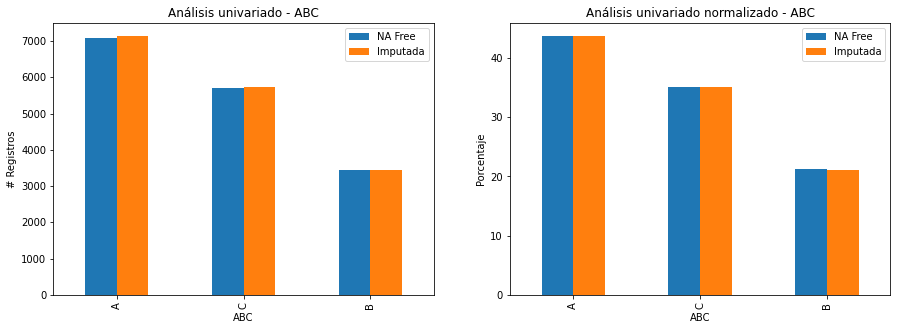

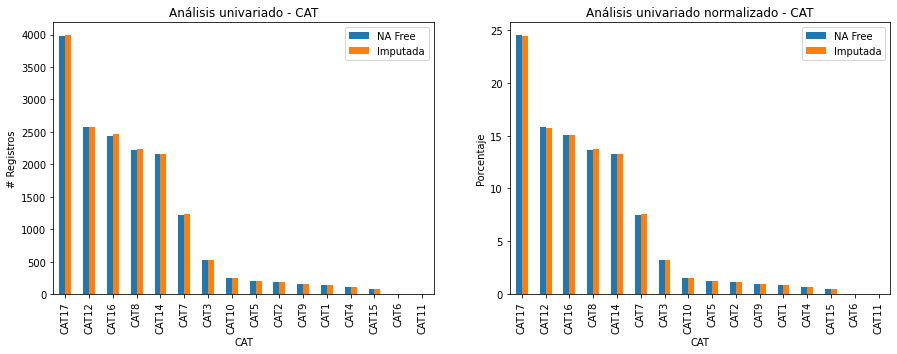

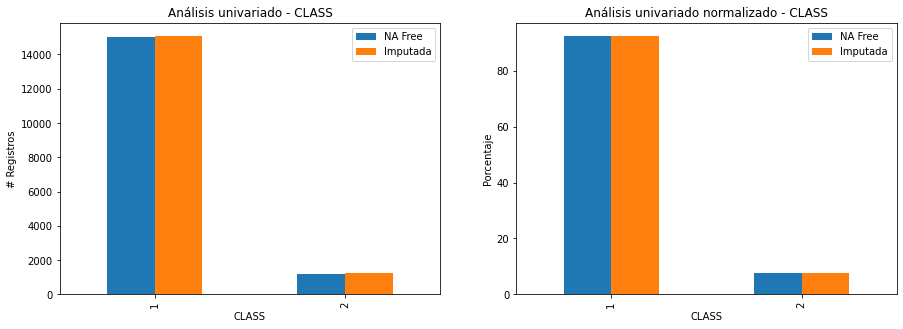

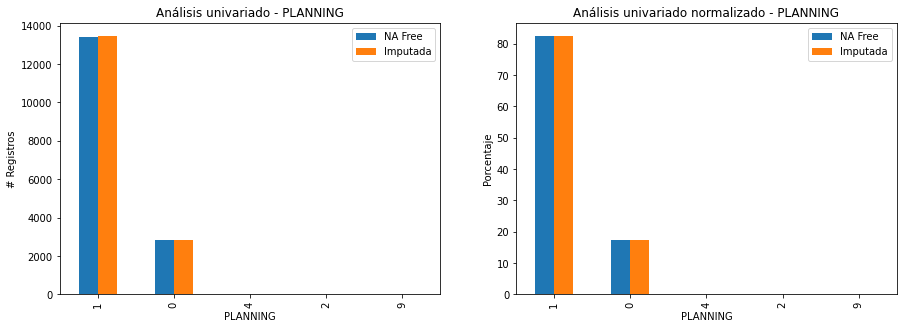

In [ ]:
import matplotlib.pyplot as plt
def analisis_univariado_categorico(colname):
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  chart = pd.DataFrame({
      'NA Free':df_na_free[colname].value_counts(),
      'Imputada':df_imp[colname].value_counts()})
  chart.plot(kind= 'bar', title = f'Análisis univariado - {colname}', ax = axs[0])
  axs[0].set_ylabel('# Registros')
  axs[0].set_xlabel(colname)
  
  chart = pd.DataFrame({
      'NA Free':df_na_free[colname].value_counts(normalize=True)*100,
      'Imputada':df_imp[colname].value_counts(normalize=True)*100})
  chart.plot(kind= 'bar', title = f'Análisis univariado normalizado - {colname}', ax = axs[1])
  axs[1].set_ylabel('Porcentaje')
  axs[1].set_xlabel(colname)


analisis_univariado_categorico('ABC')
analisis_univariado_categorico('CAT')
analisis_univariado_categorico('CLASS')
analisis_univariado_categorico('PLANNING')

In [ ]:
df.select_dtypes('object').nunique()

SKU       5295
LOC       4382
AISLE       44
COLUMN      34
TYPE         4
IG          65
HTS        134
CLASS        2
ABC          3
UOM         14
CAT         16
dtype: int64

In [ ]:
df['PLANNING'].value_counts()

1    13485
0     2833
4        9
2        4
9        2
Name: PLANNING, dtype: int64

In [ ]:
df=df[df['PLANNING']!=9]

In [ ]:
df.loc[(df['PLANNING']!=0) & (df['PLANNING']!=1),'PLANNING']=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df.PLANNING=df.PLANNING.astype(str)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df['PLANNING'].value_counts()

1    13498
0     2833
Name: PLANNING, dtype: int64

In [ ]:
df['ABC'].value_counts()

A    7137
C    5735
B    3459
Name: ABC, dtype: int64

In [ ]:
df['CLASS'].value_counts()

1    15102
2     1229
Name: CLASS, dtype: int64

In [ ]:
df['PLANNING'].value_counts(normalize=True)

1    0.826526
0    0.173474
Name: PLANNING, dtype: float64

In [ ]:
df['CAT'].value_counts(normalize=True)*100

CAT17    24.432062
CAT12    15.761435
CAT16    15.100116
CAT8     13.673382
CAT14    13.232503
CAT7      7.556181
CAT3      3.233115
CAT10     1.549201
CAT5      1.230788
CAT2      1.163432
CAT9      0.979732
CAT1      0.894005
CAT4      0.636826
CAT15     0.508236
CAT6      0.042863
CAT11     0.006123
Name: CAT, dtype: float64

In [ ]:
contingency = pd.crosstab(df_na_free['CLASS'], df_na_free['PLANNING']) 
contingency
contingency = pd.crosstab(df_imp['CLASS'], df_imp['PLANNING']) 
contingency 

PLANNING,0,1,2,4,9
CLASS,,,,,
1,1604,13485,4,9,2
2,1229,0,0,0,0


In [ ]:
contingency = pd.crosstab(df_imp['CLASS'], df_imp['PLANNING']) 
contingency 

PLANNING,0,1,2,4,9
CLASS,,,,,
1,1604,13485,4,9,2
2,1229,0,0,0,0


In [ ]:
contingency_pct= pd.crosstab(df['CLASS'], df['PLANNING'],normalize='index') 

In [ ]:
contingency_pct

PLANNING,0,1
CLASS,,
1,0.106211,0.893789
2,1.000000,0.000000


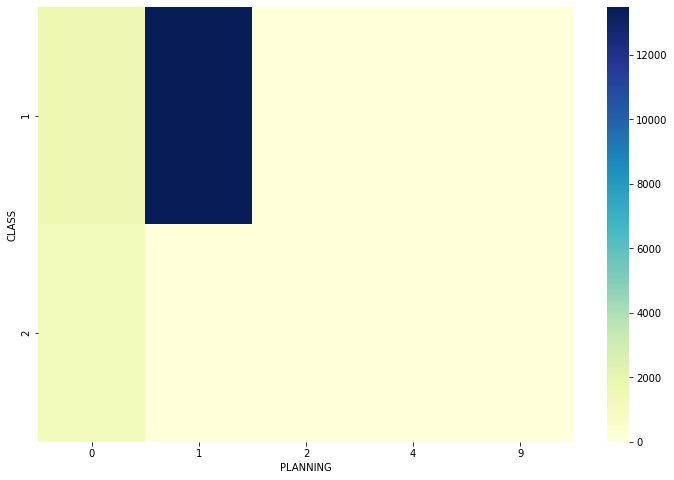

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [ ]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is greater than 0.05, so we believe the variables are independent

0.0


In [ ]:
contingency = pd.crosstab(df_na_free['IG'], df_na_free['CAT']) 
contingency


CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
IG,,,,,,,,,,,,,,,,
IG10,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0
IG11,0,0,0,0,0,0,0,0,0,0,0,200,0,0,0,0
IG12,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0
IG13,0,0,0,0,0,0,0,0,0,344,0,0,0,0,0,0
IG14,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1030,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IG7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,296,0
IG70,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0
IG71,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
contingency_pct= pd.crosstab(df['IG'], df['CAT'],normalize='index') 

In [ ]:
contingency_pct

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
IG,,,,,,,,,,,,,,,,
IG10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.00000,0.000000,0.000000
IG11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.00000,0.000000,0.000000
IG12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
IG13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
IG14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.02058,0.975678,0.003742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IG7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,1.000000,0.000000
IG70,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
IG71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000


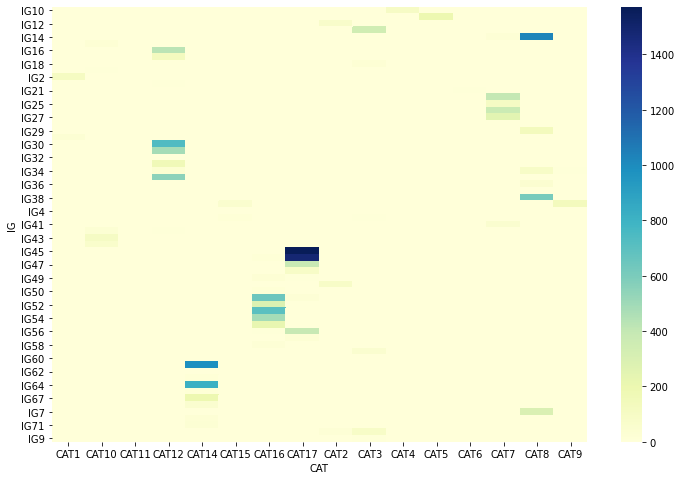

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [ ]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is greater than 0.05, so we believe the variables are independent

0.0


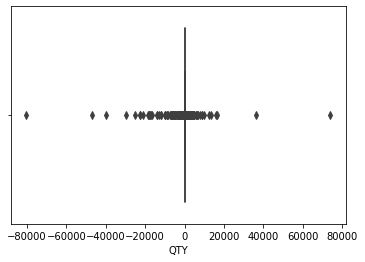

In [ ]:
sns.boxplot(x=df['QTY'])

In [ ]:
z = np.abs(stats.zscore(df.QTY))
#z = stats.zscore(df.QTY)
df['Zqty']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01746244 0.01903581 0.02139587 ... 0.03004943 0.01510238 0.01746244]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
6504,2019-03-22,SKU9182,41B9,-4.0,41,B,9,LOC4,IG22,HTS48,1,1,A,RL,CAT7,-624.8001,494.0,-0.81,2.0000,6.50,4.00,6.50,0.09,0.015102
7196,2019-05-06,SKU3352,04N3,-31.0,4,N,3,LOC4,IG31,HTS55,1,1,A,YD,CAT12,-1374.2219,300.0,-10.33,1.7421,100.00,10.00,10.00,0.03,0.006138
10683,2020-12-13,SKU10695,02L6,33.0,2,L,6,LOC4,IG35,HTS51,1,1,A,YD,CAT12,1576.4421,0.0,1.00,2.0370,121.25,7.25,7.25,0.01,0.044210
14987,2020-12-13,SKU6573,02S2,3.0,2,S,2,LOC4,IG38,HTS61,1,1,B,SQFT,CAT8,17.0427,423.0,0.71,0.0700,148.00,3.00,7.00,0.00,0.020609
5577,2019-01-30,SKU10702,04K3,-34.0,4,K,3,LOC4,IG35,HTS51,1,1,A,YD,CAT12,-2053.8792,34.0,-100.00,4.2590,121.25,7.25,7.25,0.03,0.008498


In [ ]:
df['QTY'].describe()

count    16331.000000
mean       -23.197432
std       1271.192066
min     -80500.000000
25%         -6.000000
50%         -1.000000
75%          4.000000
max      74000.000000
Name: QTY, dtype: float64

In [ ]:
df['Zqty'].describe()

count    16331.000000
mean         0.100909
std          0.994926
min          0.000155
25%          0.016676
50%          0.019036
75%          0.026903
max         63.310076
Name: Zqty, dtype: float64

In [ ]:
print('Dentro de 1 desviación estándar:', df.loc[df['Zqty'] < 1,'Zqty'].count(), round(df.loc[df['Zqty'] < 1,'Zqty'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count())
print('Más de de 3 desviación estándar:', df.loc[df['Zqty'] > 3,'Zqty'].count())
print(df.loc[df['Zqty'] < 1,'Zqty'].count() + df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count() + df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count() + df.loc[df['Zqty'] > 3,'Zqty'].count())

Dentro de 1 desviación estándar: 16124 98.73 %
Entre 1 y 2 desviaciones estándar: 112
Entre 2 y 3 desviaciones estándar: 27
Más de de 3 desviación estándar: 68
16331


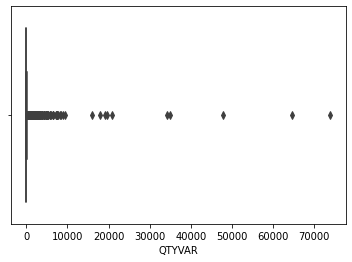

In [ ]:
sns.boxplot(x=df['QTYVAR'])

In [ ]:
df[df['QTYVAR']>10000]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
1388,2018-04-23,SKU7186,14O7,159.0,14,O,7,LOC4,IG45,HTS16,1,0,B,PC,CAT17,4.912834e+03,1.0,15900.00,0.800,6.5,4.0,7.0,0.00,0.143332
2449,2018-07-23,SKU1916,16O4,208.0,16,O,4,LOC4,IG49,HTS119,1,1,C,PC,CAT16,4.778136e+03,1.0,20800.00,1.130,30.0,1.5,1.5,0.00,0.181880
3271,2018-09-19,SKU6513,02K1,1719.0,2,K,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,3.372806e+03,9.0,19100.00,0.060,148.0,3.0,11.0,0.16,1.370565
4142,2018-10-29,SKU10933,20D2,647.0,20,D,2,LOC4,IG48,HTS24,1,0,B,TB,CAT17,1.374824e+06,1.0,64700.00,5.000,192.0,1.0,2.0,0.00,0.527236
5215,2019-01-16,SKU6481,02P1,3327.0,2,P,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,8.974852e+03,17.0,19570.59,0.100,148.0,3.0,11.0,0.02,2.635558
5228,2019-01-16,SKU6580,02P1,1746.0,2,P,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,9.931164e+03,5.0,34920.00,0.070,148.0,3.0,7.0,0.19,1.391805
5232,2019-01-16,SKU6621,02K3,1479.0,2,K,3,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,4.704755e+03,2.0,73950.00,0.020,148.0,3.0,7.0,0.01,1.181760
5562,2019-01-29,SKU4707,04D1,343.0,4,D,1,LOC4,IG30,HTS46,1,1,A,YD,CAT12,8.827518e+03,1.0,34300.00,2.336,112.0,8.5,8.5,0.16,0.288083
9155,2019-12-23,SKU7427,41E13,179.0,41,E,13,LOC5,IG26,HTS56,1,1,A,BX,CAT7,2.468232e+04,1.0,17900.00,4.000,13.0,3.0,12.0,0.32,0.159066
10583,2020-12-13,SKU10605,23F1,479.0,23,F,1,LOC4,IG55,HTS95,1,1,C,FT,CAT16,1.151114e+03,1.0,47900.00,70.000,194.0,4.0,4.0,0.00,0.395072


In [ ]:
z = np.abs(stats.zscore(df.QTYVAR))
#z = stats.zscore(df.QTYVAR)
df['ZqtyVar']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.03760993 0.01118555 0.01272359 ... 0.09531532 0.13073123 0.08291296]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
6799,2019-04-10,SKU7715,14R2,19.0,14,R,2,LOC4,IG45,HTS16,1,0,B,PC,CAT17,569.4709,64.0,29.69,0.9000,8.90,2.7,6.00,0.00,0.033196,0.006700
755,2018-03-08,SKU10656,03O2,-25.0,3,O,2,LOC4,IG31,HTS55,1,1,A,YD,CAT12,-1294.3336,25.0,-100.00,3.1444,114.00,7.5,7.50,0.23,0.001418,0.130731
1578,2018-05-04,SKU10038,12K2,4.0,12,K,2,LOC4,IG46,HTS119,1,1,C,PC,CAT17,71.3387,526.0,0.76,0.2000,5.75,1.0,3.25,0.00,0.021396,0.034368
3149,2018-09-07,SKU11377,DAVE1,-10.0,0,,0,AREA,IG25,HTS48,1,1,B,BG,CAT7,-892.6027,10.0,-100.00,1.0000,10.50,1.5,3.00,0.01,0.010382,0.130731
8042,2019-07-24,SKU8632,13T5,5.0,13,T,5,LOC4,IG53,HTS119,1,1,A,PC,CAT16,76.4785,2.0,250.00,0.5500,28.00,1.0,3.00,0.04,0.022183,0.203997


In [ ]:
df['QTYVAR'].describe()

count    16331.000000
mean        36.695891
std       1045.657353
min       -100.000000
25%        -50.120000
50%         -1.190000
75%          4.735000
max      73950.000000
Name: QTYVAR, dtype: float64

In [ ]:
df['ZqtyVar'].describe()

count    16331.000000
mean         0.111749
std          0.993767
min          0.000006
25%          0.034138
50%          0.040890
75%          0.130731
max         70.688134
Name: ZqtyVar, dtype: float64

In [ ]:
print('Dentro de 1 desviación estándar:', df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count(), round(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())
print(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count() + df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())

Dentro de 1 desviación estándar: 16196 99.17 %
Entre 1 y 2 desviaciones estándar: 58
Entre 2 y 3 desviaciones estándar: 26
Más de de 3 desviación estándar: 51
16331


In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

QTY            10.000000
SHELF           3.000000
COSTX        1354.906200
QTYBEFORE     112.000000
QTYVAR         54.855000
PESO            9.530000
LARGO          96.000000
ALTO            5.750000
ANCHO           5.500000
CONTRPERC       0.030000
Zqty            0.010227
ZqtyVar         0.096593
dtype: float64


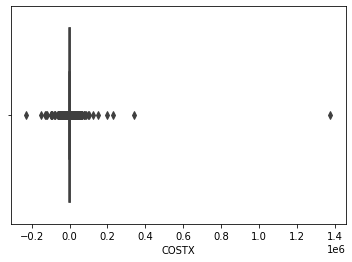

In [ ]:
sns.boxplot(x=df['COSTX'])

In [ ]:
z = np.abs(stats.zscore(df.COSTX))
#z = stats.zscore(df.COSTX)
df['ZcostX']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01672112 0.02676037 0.08842641 ... 0.37721488 0.09421688 0.01411867]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['ZcostX'].describe()

count    16331.000000
mean         0.191244
std          0.981573
min          0.000006
25%          0.014897
50%          0.051120
75%          0.145559
max        103.173820
Name: ZcostX, dtype: float64

In [ ]:
print('Dentro de 1 desviación estándar:', df.loc[df['ZcostX'] < 1,'ZcostX'].count(), round(df.loc[df['ZcostX'] < 1,'ZcostX'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZcostX'] >= 1) & (df['ZcostX'] < 2),'ZcostX'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZcostX'] >= 2) & (df['ZcostX'] < 3),'ZcostX'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZcostX'] > 3,'ZcostX'].count())
print(df.loc[df['ZcostX'] < 1,'ZcostX'].count() + df.loc[(df['ZcostX'] >= 1) & (df['ZcostX'] < 2),'ZcostX'].count() + df.loc[(df['ZcostX'] >= 2) & (df['ZcostX'] < 3),'ZcostX'].count() + df.loc[df['ZcostX'] > 3,'ZcostX'].count())

Dentro de 1 desviación estándar: 15723 96.28 %
Entre 1 y 2 desviaciones estándar: 412
Entre 2 y 3 desviaciones estándar: 109
Más de de 3 desviación estándar: 87
16331


In [ ]:
# Intentemos eliminando aquellos valores de COSTX a más de tres desviaciones estándar de la media
dfTest1=df[df['ZcostX']<3]

In [ ]:
dfTest1.describe()

,QTY,SHELF,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
count,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000,16244.000000
mean,-22.985795,3.810392,-149.335459,538.048218,31.304320,13.537335,53.921540,4.820271,5.699295,0.085813,0.088855,0.106467,0.157170
std,869.621489,2.829668,4736.959163,4481.552909,913.057319,42.943015,64.888389,4.617380,4.324386,0.408376,0.678325,0.866717,0.318892
min,-47000.000000,0.000000,-40013.935000,-44.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000155,0.000006,0.000006
25%,-6.000000,2.000000,-727.162600,2.000000,-50.000000,0.460000,6.000000,1.500000,2.500000,0.000000,0.016676,0.034138,0.014789
50%,-1.000000,3.000000,-33.079050,18.000000,-1.180000,2.020000,12.000000,3.500000,5.500000,0.010000,0.019036,0.040718,0.050318
75%,4.000000,5.000000,614.167300,113.000000,4.635000,9.800000,102.000000,7.250000,8.000000,0.030000,0.026116,0.130731,0.143682
max,16624.000000,36.000000,39709.661400,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,36.956053,70.688134,2.997672


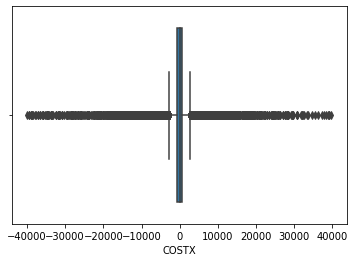

In [ ]:
sns.boxplot(x=dfTest1['COSTX'])

In [ ]:
# Borramos las columnas irrelevantes
dfTest1 = dfTest1.drop(['ZcostX'], axis=1)
z = np.abs(stats.zscore(dfTest1.COSTX))
#z = stats.zscore(dfTest1.COSTX)
dfTest1['ZcostX']=z

In [ ]:
dfTest1['ZcostX'].describe()

count    16244.000000
mean         0.444054
std          0.896027
min          0.000039
25%          0.047379
50%          0.140054
75%          0.407051
max          8.415911
Name: ZcostX, dtype: float64

In [ ]:
print('Dentro de 1 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count(), round(dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', dfTest1.loc[(dfTest1['ZcostX'] >= 1) & (dfTest1['ZcostX'] < 2),'ZcostX'].count())
print('Entre 2 y 3 desviaciones estándar:', dfTest1.loc[(dfTest1['ZcostX'] >= 2) & (dfTest1['ZcostX'] < 3),'ZcostX'].count())
print('Más de de 3 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] > 3,'ZcostX'].count())
print(dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count() + dfTest1.loc[(dfTest1['ZcostX'] >= 1) & (dfTest1['ZcostX'] < 2),'ZcostX'].count() + dfTest1.loc[(dfTest1['ZcostX'] >= 2) & (dfTest1['ZcostX'] < 3),'ZcostX'].count() + dfTest1.loc[dfTest1['ZcostX'] > 3,'ZcostX'].count())

Dentro de 1 desviación estándar: 14537 89.01 %
Entre 1 y 2 desviaciones estándar: 893
Entre 2 y 3 desviaciones estándar: 350
Más de de 3 desviación estándar: 464
16244


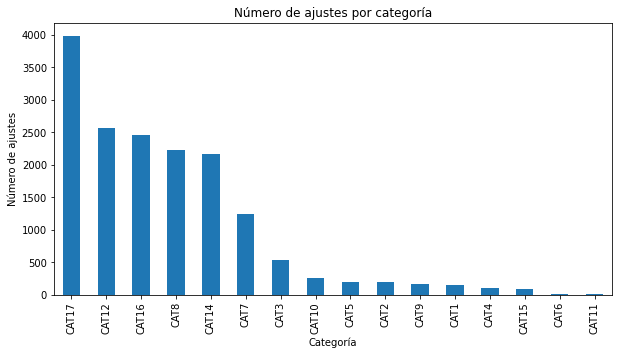

In [ ]:
# Plotting a Histogram
df.CAT.value_counts().plot(kind='bar', figsize=(10,5))
# nlargest(40).
plt.title('Número de ajustes por categoría')
plt.ylabel('Número de ajustes')
plt.xlabel('Categoría');

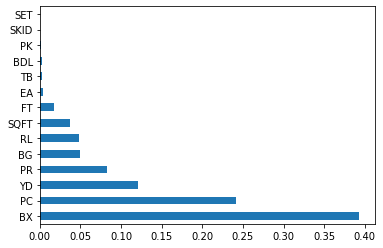

In [ ]:
df.UOM.value_counts(normalize=True).plot.barh()
plt.show()

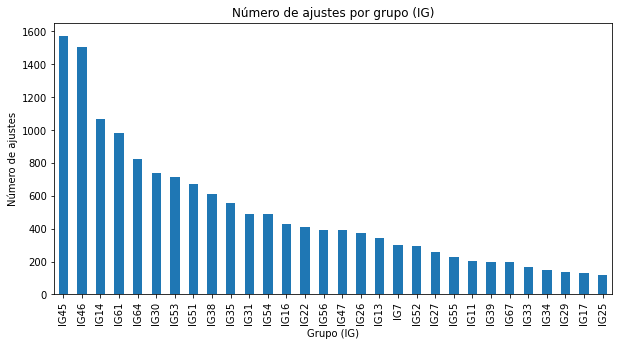

In [ ]:
# Plotting a Histogram
df.IG.value_counts().nlargest(30).plot(kind='bar', figsize=(10,5))
plt.title('Número de ajustes por grupo (IG)')
plt.ylabel('Número de ajustes')
plt.xlabel('Grupo (IG)');

HTS119    23.12
HTS15     17.98
HTS24      9.35
HTS6       7.53
HTS61      4.60
HTS95      4.29
HTS48      3.22
HTS51      3.13
HTS55      2.66
HTS56      2.57
HTS121     2.46
HTS50      1.57
HTS16      1.46
HTS36      1.20
HTS46      0.99
Name: HTS, dtype: float64 %


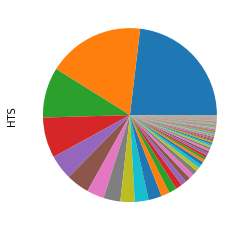

In [ ]:
print(round(df.HTS.value_counts(normalize=True).nlargest(15)*100,2),'%')
df.HTS.value_counts(normalize=True).plot.pie(labels=None)
plt.show()

,QTY,SHELF,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
QTY,1.000000,-0.012782,0.109469,-0.287369,0.029692,0.005537,0.012577,0.015798,0.018724,0.002920,-0.335536,0.021781,0.000630
SHELF,-0.012782,1.000000,-0.025356,-0.002057,-0.009988,-0.029271,-0.006189,-0.009136,-0.047424,0.006373,-0.003302,-0.002877,0.029521
COSTX,0.109469,-0.025356,1.000000,-0.014886,0.430199,-0.004831,0.008786,-0.007526,-0.006588,-0.022205,-0.000228,0.415498,0.683109
QTYBEFORE,-0.287369,-0.002057,-0.014886,1.000000,-0.004965,-0.033703,-0.053240,-0.077967,-0.082423,-0.016445,0.400118,-0.007892,0.006014
QTYVAR,0.029692,-0.009988,0.430199,-0.004965,1.000000,-0.006142,0.024166,-0.004781,0.002353,0.006535,0.019427,0.995967,0.417799
PESO,0.005537,-0.029271,-0.004831,-0.033703,-0.006142,1.000000,0.298292,0.211835,0.174566,0.184351,-0.022005,-0.004003,0.073860
LARGO,0.012577,-0.006189,0.008786,-0.053240,0.024166,0.298292,1.000000,0.105007,0.183379,0.208231,-0.024294,0.031851,0.081045
ALTO,0.015798,-0.009136,-0.007526,-0.077967,-0.004781,0.211835,0.105007,1.000000,0.722910,0.157617,-0.026205,-0.001081,0.087760
ANCHO,0.018724,-0.047424,-0.006588,-0.082423,0.002353,0.174566,0.183379,0.722910,1.000000,0.095967,-0.024203,0.005155,0.065234
CONTRPERC,0.002920,0.006373,-0.022205,-0.016445,0.006535,0.184351,0.208231,0.157617,0.095967,1.000000,-0.010968,0.005998,0.149385


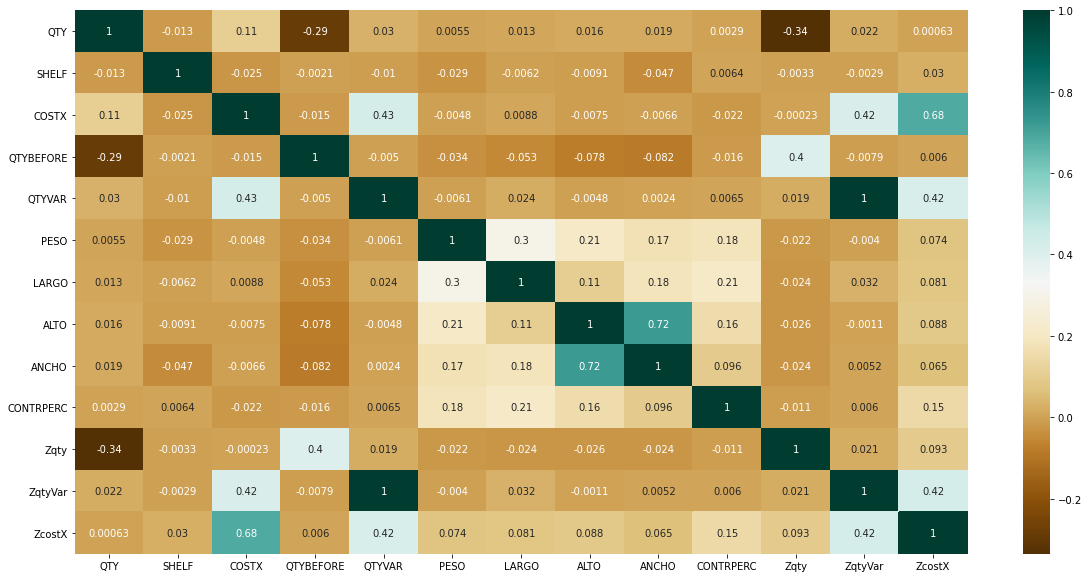

In [ ]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

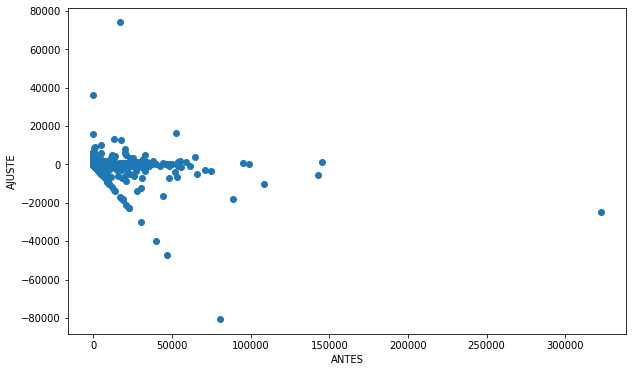

In [ ]:
# Plotting a scatter plot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['QTYBEFORE'], df['QTY'])
ax.set_xlabel('ANTES')
ax.set_ylabel('AJUSTE')
plt.show()

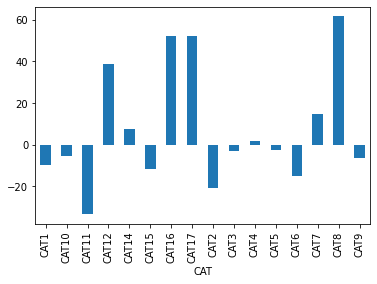

In [ ]:
df.groupby('CAT')['QTYVAR'].mean().plot.bar()
#print(result)
plt.show()

In [ ]:
df.describe()

,QTY,SHELF,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
count,16331.000000,16331.000000,1.633100e+04,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000,16331.000000
mean,-23.197432,3.814463,-6.705513e+01,544.844239,36.695891,13.664664,54.028092,4.842409,5.713911,0.089240,0.100909,0.111749,0.191244
std,1271.192066,2.835410,1.332637e+04,4520.071847,1045.657353,43.089558,64.994346,4.700794,4.384091,0.420521,0.994926,0.993767,0.981573
min,-80500.000000,0.000000,-2.298156e+05,-44.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000155,0.000006,0.000006
25%,-6.000000,2.000000,-7.367802e+02,2.000000,-50.120000,0.470000,6.000000,1.500000,2.500000,0.000000,0.016676,0.034138,0.014897
50%,-1.000000,3.000000,-3.316080e+01,18.000000,-1.190000,2.037000,12.000000,3.500000,5.500000,0.010000,0.019036,0.040890,0.051120
75%,4.000000,5.000000,6.181260e+02,114.000000,4.735000,10.000000,102.000000,7.250000,8.000000,0.030000,0.026903,0.130731,0.145559
max,74000.000000,36.000000,1.374824e+06,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,63.310076,70.688134,103.173820


In [ ]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
6179,2019-03-04,SKU5733,10H4,-2.00,10,H,4,LOC4,IG34,HTS170,1,0,...,CAT8,-450.2124,38.00,-5.26,1.48,3.875,3.00,16.75,0.00,0.016676,0.040125,0.028753
15912,2020-12-13,SKU8000,19C8,-2.00,19,C,8,LOC4,IG45,HTS24,1,1,...,CAT17,-62.5973,2.00,-100.00,2.02,72.000,1.38,1.38,0.01,0.016676,0.130731,0.000335
5641,2019-01-31,SKU1403,08U2,-3.00,8,U,2,LOC4,IG16,HTS119,1,1,...,CAT12,-483.5699,16.00,-18.75,3.22,7.500,2.80,5.90,0.07,0.015889,0.053027,0.031256
8688,2019-10-21,SKU6531,02Q1,41.00,2,Q,1,LOC4,IG38,HTS61,1,1,...,CAT8,66.4808,4207.00,0.97,0.06,148.000,3.00,11.00,0.01,0.050503,0.034167,0.010021
1326,2018-04-16,SKU2905,32C2,-0.94,32,C,2,LOC4,IG61,HTS6,1,1,...,CAT14,-783.6062,29.94,-3.14,79.70,192.000,6.00,6.00,4.63,0.017510,0.038098,0.053771


In [ ]:
df.query('LARGO > ALTO')

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
28,2018-02-10,SKU3992,12I6,-144.0,12,I,6,LOC4,IG46,HTS119,1,1,...,CAT17,-8177.0401,144.0,-100.00,1.7,36.5,3.250,3.00,0.01,0.095034,0.130731,0.608585
29,2018-02-10,SKU3992,17E5,-4.0,17,E,5,LOC4,IG46,HTS119,1,1,...,CAT17,-227.1400,102.0,-3.92,1.7,36.5,3.250,3.00,0.01,0.015102,0.038844,0.012013
30,2018-02-10,SKU3992,17V1,3.0,17,V,1,LOC4,IG46,HTS119,1,1,...,CAT17,170.3550,158.0,1.90,1.7,36.5,3.250,3.00,0.01,0.020609,0.033278,0.017816
31,2018-02-10,SKU3993,13L6,-6.0,13,L,6,LOC4,IG46,HTS119,1,1,...,CAT17,-340.7100,97.0,-6.19,1.7,36.5,3.250,3.00,0.04,0.013529,0.041015,0.020535
32,2018-02-10,SKU3993,13T1,-52.0,13,T,1,LOC4,IG46,HTS119,1,1,...,CAT17,-2952.8200,53.0,-98.11,1.7,36.5,3.250,3.00,0.04,0.022659,0.128924,0.216552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,2020-12-13,SKU8964,23C10,1.0,23,C,10,LOC5,IG5,HTS67,1,0,...,CAT2,316.3834,0.0,1.00,45.0,162.0,2.375,6.00,0.00,0.019036,0.034138,0.028774
17003,2020-12-13,SKU8971,21I2,2.0,21,I,2,LOC4,IG5,HTS67,1,0,...,CAT2,626.9100,0.0,1.00,45.0,162.0,2.375,6.00,0.00,0.019822,0.034138,0.052076
17004,2020-12-13,SKU8972,22F8,15.0,22,F,8,LOC4,IG5,HTS67,1,0,...,CAT2,4959.6974,11.0,136.36,45.0,162.0,2.375,6.00,0.00,0.030049,0.095315,0.377215
17005,2020-12-13,SKU8972,24I4,-4.0,24,I,4,LOC4,IG5,HTS67,1,0,...,CAT2,-1322.5860,4.0,-100.00,45.0,162.0,2.375,6.00,0.00,0.015102,0.130731,0.094217


In [ ]:
# Notas / pendientes
# Crear buckets?
# pairplot?
# pd.set_option('display.max_columns', None)
# Heatmap por grupos:
# result = pd.pivot_table(data=df, index='CATEGORICAL1', columns='CATEGORICAL2',values='NUMERICA')
# plt.show()
# Escalar
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)

In [ ]:

dfTest1.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
13744,2020-12-13,SKU4370,14Q8,-2.0,14,Q,8,LOC4,IG46,HTS119,1,1,...,CAT17,-40.9385,2.0,-100.00,0.750,4.75,3.00,4.00,0.01,0.016676,0.130731,0.022884
14900,2020-12-13,SKU6371,15V2,10.0,15,V,2,LOC4,IG45,HTS24,1,1,...,CAT17,118.2405,7.0,142.86,0.450,8.50,2.50,8.25,0.00,0.026116,0.101532,0.056489
8313,2019-08-27,SKU10979,27C3,-512.0,27,C,3,LOC4,IG55,HTS95,1,1,...,CAT16,-2231.6631,6400.0,-8.00,0.386,0.22,0.22,0.22,0.08,0.384535,0.042746,0.439605
16037,2020-12-13,SKU8125,16K2,10.0,16,K,2,LOC4,IG45,HTS24,1,1,...,CAT17,162.0558,0.0,1.00,0.600,8.00,2.50,6.50,0.00,0.026116,0.034138,0.065739
5309,2019-01-17,SKU6689,02T3,-14.0,2,T,3,LOC4,IG38,HTS61,1,1,...,CAT8,-76.5817,14.0,-100.00,0.090,148.00,3.00,7.00,0.01,0.007236,0.130731,0.015359


In [ ]:
print("Peso  (0):",dfTest1.loc[dfTest1['PESO']==0].shape[0]);
print("Largo (0):",dfTest1.loc[dfTest1['LARGO']==0].shape[0]);
print("Ancho (0):",dfTest1.loc[dfTest1['ANCHO']==0].shape[0]);
print("Alto  (0):",dfTest1.loc[dfTest1['ALTO']==0].shape[0]);

Peso  (0): 1004
Largo (0): 1282
Ancho (0): 1282
Alto  (0): 1282


In [ ]:
dfTest1.dtypes

TDATE        datetime64[ns]
SKU                  object
LOC                  object
QTY                 float64
AISLE                object
COLUMN               object
SHELF                 int64
TYPE                 object
IG                   object
HTS                  object
CLASS                object
PLANNING             object
ABC                  object
UOM                  object
CAT                  object
COSTX               float64
QTYBEFORE           float64
QTYVAR              float64
PESO                float64
LARGO               float64
ALTO                float64
ANCHO               float64
CONTRPERC           float64
Zqty                float64
ZqtyVar             float64
ZcostX              float64
dtype: object

In [ ]:
# Para nueva prueba
dfTest2 = dfTest1

In [ ]:
# Borramos las columnas que no serán utilizados en este primer intento
dfTest1 = dfTest1.drop(['TDATE','SKU','LOC','COLUMN','SHELF','TYPE','QTYBEFORE','PESO','LARGO','ALTO','ANCHO','Zqty','ZqtyVar','ZcostX','QTY'], axis=1)

In [ ]:
dfTest1['PLANNING'] =dfTest1['CLASS'] + "/" + dfTest1['PLANNING']

In [ ]:
dfTest1 = dfTest1.drop(['CLASS'], axis=1)

In [ ]:
dfTest1['PLANNING'].value_counts()

1/1    13432
1/0     1590
2/0     1222
Name: PLANNING, dtype: int64

In [ ]:
dfTest1.dtypes

AISLE         object
IG            object
HTS           object
PLANNING      object
ABC           object
UOM           object
CAT           object
COSTX        float64
QTYVAR       float64
CONTRPERC    float64
dtype: object

In [ ]:
dfTest1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16244 entries, 0 to 17006
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AISLE      16244 non-null  object 
 1   IG         16244 non-null  object 
 2   HTS        16244 non-null  object 
 3   PLANNING   16244 non-null  object 
 4   ABC        16244 non-null  object 
 5   UOM        16244 non-null  object 
 6   CAT        16244 non-null  object 
 7   COSTX      16244 non-null  float64
 8   QTYVAR     16244 non-null  float64
 9   CONTRPERC  16244 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.4+ MB


In [ ]:
dfTest1.to_csv("dfNoDims.csv", index = False)

In [ ]:
# Get the position of categorical columns
catColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfTest1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [ ]:
# Get the position of numerical columns
numColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfTest1.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR', 'CONTRPERC']
Numerical columns position : [7, 8, 9]


In [ ]:
numdf = dfTest1[list(dfTest1.select_dtypes('float64').columns)]

In [ ]:
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR,CONTRPERC
0,-0.029671,-0.037167,-0.185651
1,0.092655,-0.006905,-0.210139
2,0.266138,0.020477,-0.210139
3,-0.024812,-0.044242,-0.210139
4,-0.077628,-0.046455,-0.210139
...,...,...,...
17002,0.098319,-0.033191,-0.210139
17003,0.163875,-0.033191,-0.210139
17004,1.078580,0.115063,-0.210139
17005,-0.247688,-0.143812,-0.210139


In [ ]:
catdf = dfTest1[list(dfTest1.select_dtypes('object').columns)]

In [ ]:
print("catdf",catdf.shape)
print("scaled_features_df",scaled_features_df.shape)
print(catdf.head(5))
print(scaled_features_df.head(5))
print(catdf.tail(5))
print(scaled_features_df.tail(5))
dfNoSupervisado1 = pd.concat((catdf, scaled_features_df), axis = 1)
dfNoSupervisado1

catdf (16244, 7)
scaled_features_df (16244, 3)
  AISLE    IG     HTS PLANNING ABC UOM    CAT
0    17  IG56  HTS119      1/1   B  PC  CAT17
1    17  IG56  HTS119      1/1   B  PC  CAT17
2    17  IG56  HTS119      1/1   C  PC  CAT17
3    17  IG56  HTS119      1/1   B  PC  CAT17
4    15  IG56  HTS119      1/1   C  PC  CAT17
      COSTX    QTYVAR  CONTRPERC
0 -0.029671 -0.037167  -0.185651
1  0.092655 -0.006905  -0.210139
2  0.266138  0.020477  -0.210139
3 -0.024812 -0.044242  -0.210139
4 -0.077628 -0.046455  -0.210139
      AISLE   IG    HTS PLANNING ABC UOM   CAT
17002    23  IG5  HTS67      1/0   C  BX  CAT2
17003    21  IG5  HTS67      1/0   C  BX  CAT2
17004    22  IG5  HTS67      1/0   C  BX  CAT2
17005    24  IG5  HTS67      1/0   C  BX  CAT2
17006    20  IG5  HTS67      1/0   C  BX  CAT2
          COSTX    QTYVAR  CONTRPERC
17002  0.098319 -0.033191  -0.210139
17003  0.163875 -0.033191  -0.210139
17004  1.078580  0.115063  -0.210139
17005 -0.247688 -0.143812  -0.210139
17006 -0.022

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,CONTRPERC
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029671,-0.037167,-0.185651
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092655,-0.006905,-0.210139
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266138,0.020477,-0.210139
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.024812,-0.044242,-0.210139
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077628,-0.046455,-0.210139
...,...,...,...,...,...,...,...,...,...,...
17002,23,IG5,HTS67,1/0,C,BX,CAT2,0.098319,-0.033191,-0.210139
17003,21,IG5,HTS67,1/0,C,BX,CAT2,0.163875,-0.033191,-0.210139
17004,22,IG5,HTS67,1/0,C,BX,CAT2,1.078580,0.115063,-0.210139
17005,24,IG5,HTS67,1/0,C,BX,CAT2,-0.247688,-0.143812,-0.210139


In [ ]:
df.loc[df['QTYVAR']==0, ['QTYBEFORE','QTY']]

,QTYBEFORE,QTY
6848,31801.0,1.0
7813,22177.0,-1.0


In [ ]:
from sklearn.metrics import silhouette_score
import time

dfNoSupervisado1.reset_index(drop=True)
N = dfNoSupervisado1.shape[0]

dataNum=dfNoSupervisado1.iloc[:,numColumnsPos]
dataNum=dataNum.to_numpy()
print('Datos numéricos',type(dataNum))

dataCat=dfNoSupervisado1.iloc[:,catColumnsPos]
dataCat=dataCat.to_numpy()
print('Datos categóricos',type(dataCat))

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

# Inicializamos la matriz de distancias con ceros
scores = [ [ 0 for i in range(N) ] for j in range(N) ]

# Calculamos la mitad de la matriz distancias
for i in range(N):
  for j in range(i+1,N):
    scores[i][j]=np.sum((dataNum[i] - dataNum[j]) ** 2) + catWeight * np.sum(dataCat[i]!=dataCat[j])
print("Matriz de distancias --- %s seconds ---" % (time.time() - start_time))

# Completamos la matriz
for i in range(0,N):
  for j in range(0,i):
    scores[i][j]=scores[j][i]
print("Espejo --- %s seconds ---" % (time.time() - start_time))

Datos numéricos <class 'numpy.ndarray'>
Datos categóricos <class 'numpy.ndarray'>
Matriz de distancias --- 2711.189366340637 seconds ---
Espejo --- 2830.322156190872 seconds ---


In [ ]:
# gamma = 0.5 (constante)

cost = []
silueta = []
start_time = time.time()

for k in (list(range(1,6)) + [10]):
  try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
      silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
      silueta.append(silhouette_coeff)
      print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
      print(silhouette_coeff)

  except:
    break

k: 1
--- 17.552792072296143 seconds ---
k: 2
--- 76.22530674934387 seconds ---
Coeficiente silueta --- 136.1786618232727 seconds ---
0.9423754192279743
k: 3
--- 217.4081687927246 seconds ---
Coeficiente silueta --- 275.78667306900024 seconds ---
0.844711061206448
k: 4
--- 364.9137268066406 seconds ---
Coeficiente silueta --- 424.12941694259644 seconds ---
0.7824346182312063
k: 5
--- 522.6777231693268 seconds ---
Coeficiente silueta --- 580.6108915805817 seconds ---
0.11801864988885731
k: 10
--- 722.7429246902466 seconds ---
Coeficiente silueta --- 781.1515741348267 seconds ---
0.14609263859881075


In [ ]:
df_cost = pd.DataFrame({'Cluster':list(range(1,6)) + [10], 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':list(range(2,6)) + [10], 'Coeficiente':silueta})

In [ ]:
silueta

[0.9423754192279743,
 0.844711061206448,
 0.7824346182312063,
 0.11801864988885731,
 0.14609263859881075]

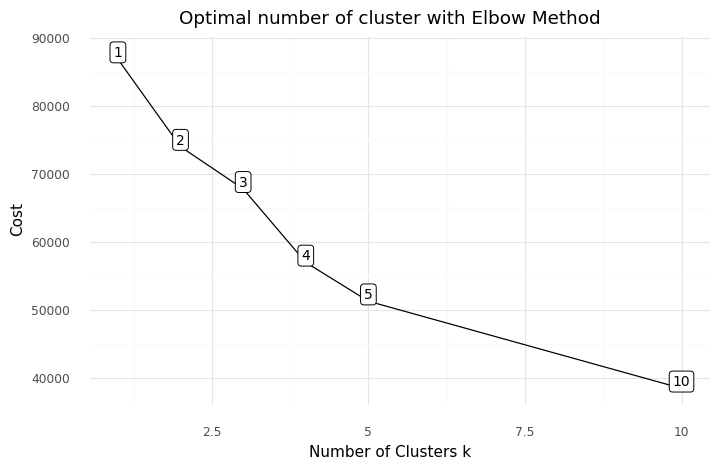

<ggplot: (8734560586181)>

In [ ]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

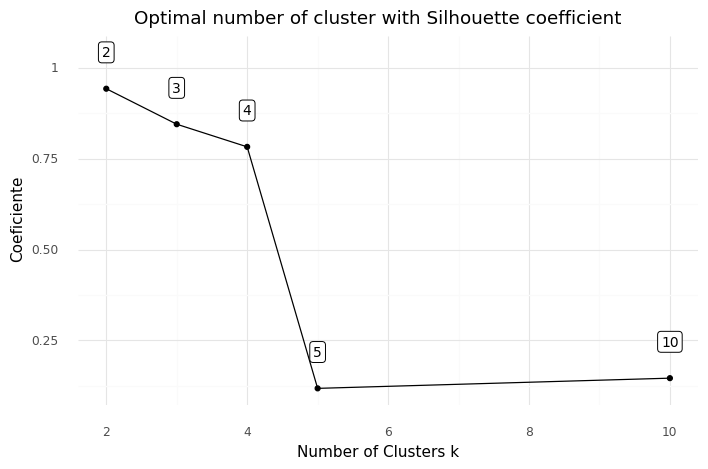

<ggplot: (8734279646189)>

In [ ]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [ ]:
# Fit the cluster 
# k = 2
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', gamma = 0.5, random_state = 0)
kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 60.73600649833679 seconds ---


In [ ]:
# Cluster centroids
print(kprototype.cluster_centroids_)
# Check the iteration of the clusters created
print(kprototype.n_iter_)
# Check the cost of the clusters created
kprototype.cost_

[['0.002368341296926517' '-0.00025311015686731365' '-0.08310161254070987'
  '2' 'IG45' 'HTS119' '1/1' 'A' 'BX' 'CAT17']
 ['-0.26666198057232515' '0.028498787661964158' '9.356776667957375' '32'
  'IG61' 'HTS6' '1/1' 'A' 'BX' 'CAT14']]
9


74069.88688737054

In [ ]:
# Add the cluster to the dataframe
dfNoSupervisado1['Cluster Labels'] = kprototype.labels_

In [ ]:
dfNoSupervisado1.to_csv("k2NoDims.csv", index = False)

In [ ]:
dfNoSupervisado1['Cluster Labels'].unique()

array([0, 1], dtype=uint16)

In [ ]:
np.unique(kprototype.labels_)

array([0, 1], dtype=uint16)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['CAT']) 
contingency

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
Cluster Labels,,,,,,,,,,,,,,,,
0,146,251,1,2558,1996,83,2455,3988,190,519,104,200,7,1222,2221,160
1,0,0,0,0,143,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['IG']) 
contingency

IG,IG10,IG11,IG12,IG13,IG14,IG15,IG16,IG17,IG18,IG19,IG2,IG20,IG21,IG22,IG25,IG26,IG27,IG28,IG29,IG3,IG30,IG31,IG32,IG33,IG34,IG35,IG36,IG37,IG38,IG39,IG4,IG40,IG41,IG42,IG43,IG44,IG45,IG46,IG47,IG48,IG49,IG5,IG50,IG51,IG52,IG53,IG54,IG55,IG56,IG57,IG58,IG6,IG60,IG61,IG62,IG63,IG64,IG65,IG67,IG69,IG7,IG70,IG71,IG8,IG9
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,104,200,77,340,1068,29,422,129,26,13,111,10,7,396,118,376,256,1,137,32,736,489,6,165,140,558,45,1,609,199,3,27,54,42,116,71,1574,1504,389,87,36,89,17,669,292,711,487,226,393,29,29,51,5,863,4,18,781,18,198,56,288,26,32,109,7
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,0,0,32,0,0,0,0,0,0,0,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['HTS']) 
contingency

HTS,HTS10,HTS100,HTS101,HTS102,HTS103,HTS104,HTS107,HTS11,HTS110,HTS111,HTS112,HTS114,HTS115,HTS117,HTS119,HTS12,HTS120,HTS121,HTS123,HTS124,HTS132,HTS138,HTS14,HTS140,HTS143,HTS146,HTS148,HTS15,HTS150,HTS151,HTS153,HTS154,HTS155,HTS156,HTS157,HTS158,HTS159,HTS16,HTS161,HTS163,HTS164,HTS165,HTS166,HTS167,HTS168,HTS169,HTS17,HTS170,HTS171,HTS172,HTS173,HTS175,HTS18,HTS19,HTS2,HTS20,HTS21,HTS22,HTS23,HTS24,HTS25,HTS26,HTS27,HTS29,HTS3,HTS32,HTS33,HTS34,HTS35,HTS36,HTS37,HTS38,HTS39,HTS4,HTS40,HTS41,HTS42,HTS43,HTS44,HTS45,HTS46,HTS47,HTS48,HTS49,HTS5,HTS50,HTS51,HTS52,HTS53,HTS54,HTS55,HTS56,HTS57,HTS58,HTS59,HTS6,HTS60,HTS61,HTS62,HTS63,HTS65,HTS66,HTS67,HTS69,HTS71,HTS72,HTS73,HTS74,HTS75,HTS76,HTS77,HTS78,HTS79,HTS8,HTS80,HTS81,HTS82,HTS83,HTS85,HTS86,HTS89,HTS9,HTS90,HTS91,HTS92,HTS93,HTS94,HTS95,HTS96,HTS97,HTS98,HTS99,No HTS
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,1,3,2,4,4,3,3,19,2,3,3,12,106,3763,17,19,402,1,4,7,11,9,4,6,1,70,2886,20,3,9,1,3,3,2,1,2,238,18,2,5,2,20,9,3,1,79,18,1,2,12,7,21,72,1,2,1,2,118,1526,27,2,1,2,2,3,33,2,61,196,143,3,51,5,69,61,16,34,2,5,161,41,514,1,1,256,511,16,30,10,432,420,33,33,29,1110,5,752,49,1,13,105,150,5,2,3,19,3,11,76,2,9,8,3,5,10,3,1,9,9,4,51,2,1,4,6,18,691,3,156,10,4,10
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['AISLE']) 
contingency

AISLE,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,37,38,39,4,40,41,5,6,7,8,88,9,99
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70,222,633,776,1056,826,785,851,554,586,340,339,1117,247,250,226,90,87,134,82,98,166,143,805,153,151,168,177,105,81,652,186,176,751,121,158,220,193,665,704,83,699,175
1,0,0,3,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,4,0,3,18,82,1,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['PLANNING']) 
contingency

PLANNING,1/0,1/1,2/0
Cluster Labels,,,
0,1590,13289,1222
1,0,143,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['ABC']) 
contingency

ABC,A,B,C
Cluster Labels,,,
0,6933,3456,5712
1,143,0,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['UOM']) 
contingency

UOM,BDL,BG,BX,EA,FT,PC,PK,PR,RL,SET,SKID,SQFT,TB,YD
Cluster Labels,,,,,,,,,,,,,,
0,38,816,6210,60,285,3929,14,1355,774,1,2,609,44,1964
1,0,0,143,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dfNoSupervisado1[dfNoSupervisado1['Cluster Labels']==0].describe()

,COSTX,QTYVAR,CONTRPERC,Cluster Labels
count,16101.000000,16101.000000,16101.000000,16101.0
mean,0.002368,-0.000253,-0.083102,0.0
std,0.947685,1.004003,0.416489,0.0
min,-8.308003,-0.143812,-0.210139,0.0
25%,-0.120570,-0.089049,-0.210139,0.0
50%,0.024549,-0.035579,-0.185651,0.0
75%,0.157853,-0.029303,-0.161163,0.0
max,8.307268,80.959836,4.246670,0.0


In [ ]:
dfNoSupervisado1[dfNoSupervisado1['Cluster Labels']==1].describe()

,COSTX,QTYVAR,CONTRPERC,Cluster Labels
count,143.000000,143.000000,143.000000,143.0
mean,-0.266662,0.028499,9.356777,1.0
std,3.534762,0.322169,2.403798,0.0
min,-8.415911,-0.143812,5.495556,1.0
25%,-2.701571,-0.090424,7.650497,1.0
50%,-0.130681,-0.037725,11.127787,1.0
75%,2.143386,0.007443,11.127787,1.0
max,8.414728,3.032428,11.127787,1.0


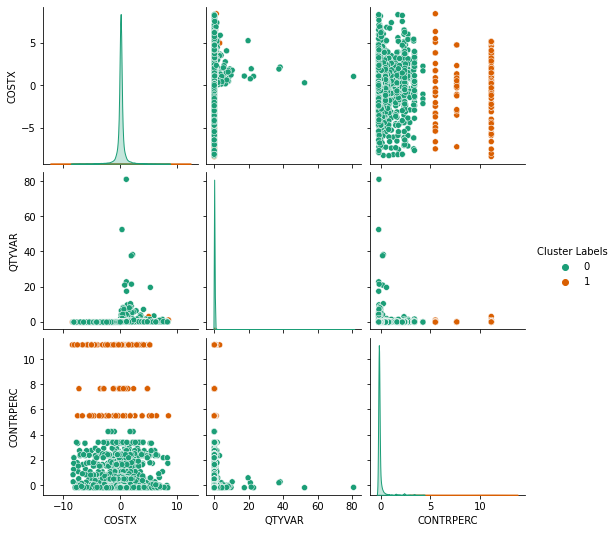

In [ ]:
sns.pairplot(dfNoSupervisado1,hue='Cluster Labels',palette='Dark2',diag_kind='kde')

Cluster 0: ajustes de todo rango (costo) + variación principalmente baja y contribución media baja

Cluster 1: ajustes de todo rango (costo) + variación  baja y contribución media alta

**Priorizar cluster 1?**

In [ ]:
# Fit the cluster
# k = 3
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', gamma = 0.5, random_state = 0)
kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 73.52124261856079 seconds ---


In [ ]:
# Cluster centroids
print(kprototype.cluster_centroids_)
# Check the iteration of the clusters created
print(kprototype.n_iter_)
# Check the cost of the clusters created
kprototype.cost_

[['-0.26666198057235585' '0.02849878766195622' '9.356776667957435' '1.0'
  '32' 'IG61' 'HTS6' '1/1' 'A' 'BX' 'CAT14']
 ['1.7048385391605871' '34.568548384858516' '0.02385698576148208' '0.0'
  '2' 'IG38' 'HTS61' '1/1' 'A' 'SQFT' 'CAT8']
 ['0.0014161767567346258' '-0.019586891753627562' '-0.08316143278583893'
  '0.0' '2' 'IG45' 'HTS119' '1/1' 'A' 'BX' 'CAT17']]
10


63276.65019411367

In [ ]:
# Add the cluster to the dataframe
dfNoSupervisado1['Cluster Labels'] = kprototype.labels_

In [ ]:
dfNoSupervisado1.to_csv("k3NoDims.csv", index = False)

In [ ]:
dfNoSupervisado1['Cluster Labels'].unique()

array([2, 0, 1], dtype=uint16)

In [ ]:
np.unique(kprototype.labels_)

array([0, 1, 2], dtype=uint16)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['CAT']) 
contingency

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
Cluster Labels,,,,,,,,,,,,,,,,
0,0,0,0,0,143,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,2,1,0,0,0,0,0,1,4,0
2,146,251,1,2557,1996,83,2453,3987,190,519,104,200,7,1221,2217,160


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['IG']) 
contingency

IG,IG10,IG11,IG12,IG13,IG14,IG15,IG16,IG17,IG18,IG19,IG2,IG20,IG21,IG22,IG25,IG26,IG27,IG28,IG29,IG3,IG30,IG31,IG32,IG33,IG34,IG35,IG36,IG37,IG38,IG39,IG4,IG40,IG41,IG42,IG43,IG44,IG45,IG46,IG47,IG48,IG49,IG5,IG50,IG51,IG52,IG53,IG54,IG55,IG56,IG57,IG58,IG6,IG60,IG61,IG62,IG63,IG64,IG65,IG67,IG69,IG7,IG70,IG71,IG8,IG9
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,0,0,32,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,104,200,77,340,1068,29,422,129,26,13,111,10,7,396,118,375,256,1,137,32,735,489,6,165,140,558,45,1,605,199,3,27,54,42,116,71,1573,1504,389,87,35,89,17,669,292,711,487,225,393,29,29,51,5,863,4,18,781,18,198,56,288,26,32,109,7


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['HTS']) 
contingency

HTS,HTS10,HTS100,HTS101,HTS102,HTS103,HTS104,HTS107,HTS11,HTS110,HTS111,HTS112,HTS114,HTS115,HTS117,HTS119,HTS12,HTS120,HTS121,HTS123,HTS124,HTS132,HTS138,HTS14,HTS140,HTS143,HTS146,HTS148,HTS15,HTS150,HTS151,HTS153,HTS154,HTS155,HTS156,HTS157,HTS158,HTS159,HTS16,HTS161,HTS163,HTS164,HTS165,HTS166,HTS167,HTS168,HTS169,HTS17,HTS170,HTS171,HTS172,HTS173,HTS175,HTS18,HTS19,HTS2,HTS20,HTS21,HTS22,HTS23,HTS24,HTS25,HTS26,HTS27,HTS29,HTS3,HTS32,HTS33,HTS34,HTS35,HTS36,HTS37,HTS38,HTS39,HTS4,HTS40,HTS41,HTS42,HTS43,HTS44,HTS45,HTS46,HTS47,HTS48,HTS49,HTS5,HTS50,HTS51,HTS52,HTS53,HTS54,HTS55,HTS56,HTS57,HTS58,HTS59,HTS6,HTS60,HTS61,HTS62,HTS63,HTS65,HTS66,HTS67,HTS69,HTS71,HTS72,HTS73,HTS74,HTS75,HTS76,HTS77,HTS78,HTS79,HTS8,HTS80,HTS81,HTS82,HTS83,HTS85,HTS86,HTS89,HTS9,HTS90,HTS91,HTS92,HTS93,HTS94,HTS95,HTS96,HTS97,HTS98,HTS99,No HTS
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,1,3,2,4,4,3,3,19,2,3,3,12,106,3762,17,19,402,1,4,7,11,9,4,6,1,70,2886,20,3,9,1,3,3,2,1,2,237,18,2,5,2,20,9,3,1,79,18,1,2,12,7,21,72,1,2,1,2,118,1526,27,2,1,2,2,3,33,2,61,196,143,3,51,5,69,61,16,34,2,5,160,41,514,1,1,256,511,16,30,10,432,419,33,33,29,1110,5,748,49,1,13,105,150,5,2,3,19,3,11,76,2,9,8,3,5,10,3,1,9,9,4,51,2,1,4,6,18,690,3,156,10,4,10


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['AISLE']) 
contingency

AISLE,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,37,38,39,4,40,41,5,6,7,8,88,9,99
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,3,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,4,0,3,18,82,1,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,70,222,633,776,1056,826,784,851,553,586,340,339,1113,247,250,226,89,87,134,82,98,166,143,805,153,151,168,177,105,81,652,186,176,750,121,157,220,193,665,704,83,699,175


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['PLANNING']) 
contingency

PLANNING,1/0,1/1,2/0
Cluster Labels,,,
0,0,143,0
1,1,8,0
2,1589,13281,1222


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['ABC']) 
contingency

ABC,A,B,C
Cluster Labels,,,
0,143,0,0
1,6,1,2
2,6927,3455,5710


In [ ]:
contingency = pd.crosstab(dfNoSupervisado1['Cluster Labels'], dfNoSupervisado1['UOM']) 
contingency

UOM,BDL,BG,BX,EA,FT,PC,PK,PR,RL,SET,SKID,SQFT,TB,YD
Cluster Labels,,,,,,,,,,,,,,
0,0,0,143,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,2,0,0,0,0,0,4,0,1
2,38,816,6209,60,284,3927,14,1355,774,1,2,605,44,1963


In [ ]:
dfNoSupervisado1[dfNoSupervisado1['Cluster Labels']==0].describe()

,COSTX,QTYVAR,CONTRPERC,Cluster Labels
count,143.000000,143.000000,143.000000,143.0
mean,-0.266662,0.028499,9.356777,0.0
std,3.534762,0.322169,2.403798,0.0
min,-8.415911,-0.143812,5.495556,0.0
25%,-2.701571,-0.090424,7.650497,0.0
50%,-0.130681,-0.037725,11.127787,0.0
75%,2.143386,0.007443,11.127787,0.0
max,8.414728,3.032428,11.127787,0.0


In [ ]:
dfNoSupervisado1[dfNoSupervisado1['Cluster Labels']==1].describe()

,COSTX,QTYVAR,CONTRPERC,Cluster Labels
count,9.000000,9.000000,9.000000,9.0
mean,1.704839,34.568548,0.023857,1.0
std,1.460157,20.958121,0.284554,0.0
min,0.274541,17.380272,-0.210139,1.0
25%,1.024759,20.885088,-0.210139,1.0
50%,1.068687,22.747022,-0.161163,1.0
75%,1.926229,38.212026,0.181668,1.0
max,5.242270,80.959836,0.573476,1.0


In [ ]:
dfNoSupervisado1[dfNoSupervisado1['Cluster Labels']==2].describe()

,COSTX,QTYVAR,CONTRPERC,Cluster Labels
count,16092.000000,16092.000000,16092.000000,16092.0
mean,0.001416,-0.019587,-0.083161,2.0
std,0.946534,0.348489,0.416549,0.0
min,-8.308003,-0.143812,-0.210139,2.0
25%,-0.120660,-0.089049,-0.210139,2.0
50%,0.024429,-0.035590,-0.185651,2.0
75%,0.156967,-0.029303,-0.161163,2.0
max,8.307268,10.315875,4.246670,2.0


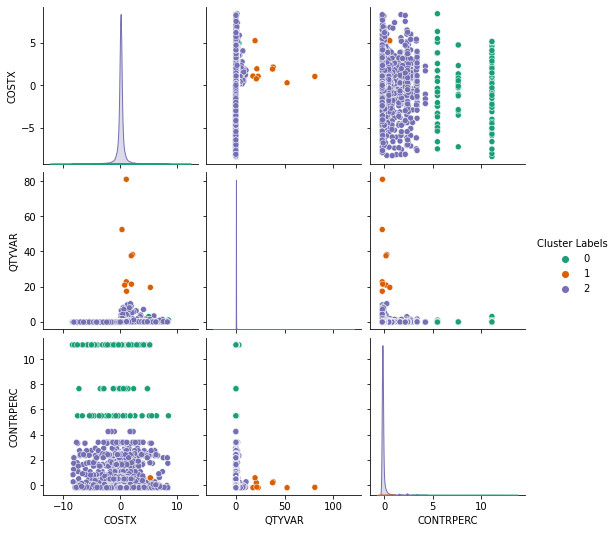

In [ ]:
sns.pairplot(dfNoSupervisado1,hue='Cluster Labels',palette='Dark2',diag_kind='kde')

Cluster 0: ajustes positivos (costo) + baja variación y contribución media baja

Cluster 1: ajustes negativos (costo) + variación todo rango pero principalmente baja y contribución media baja

Cluster 2: ajustes de todo rango (costo) + baja variación y alta contribución

**Priorizar clusters 1 y 2?**

In [ ]:
dfTest2['PLANNING'] =dfTest2['CLASS'] + "/" + dfTest2['PLANNING']

In [ ]:
# Borramos las columnas que no serán utilizados en este segundo intento
dfTest2 = dfTest2.drop(['TDATE','SKU','LOC','COLUMN','SHELF','TYPE','CLASS','QTYBEFORE','Zqty','ZqtyVar','ZcostX','QTY'], axis=1)

In [ ]:
dfTest2.dtypes

AISLE         object
IG            object
HTS           object
PLANNING      object
ABC           object
UOM           object
CAT           object
COSTX        float64
QTYVAR       float64
PESO         float64
LARGO        float64
ALTO         float64
ANCHO        float64
CONTRPERC    float64
dtype: object

In [ ]:
dfTest2.to_csv("dfDims.csv", index = False)

In [ ]:
# Get the position of categorical columns
catColumnsPos = [dfTest2.columns.get_loc(col) for col in list(dfTest2.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfTest2.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [ ]:
# Get the position of numerical columns
numColumnsPos = [dfTest2.columns.get_loc(col) for col in list(dfTest2.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfTest2.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR', 'PESO', 'LARGO', 'ALTO', 'ANCHO', 'CONTRPERC']
Numerical columns position : [7, 8, 9, 10, 11, 12, 13]


In [ ]:
#dfTest2=dfTest2.iloc[:,(dfTest2['PESO']!=0 & dfTest2['LARGO']!=0 & dfTest2['ANCHO']!=0 & dfTest2['ALTO']!=0)]
dfTest2=dfTest2[(dfTest2['PESO']!=0) & (dfTest2['LARGO']!=0) & (dfTest2['ANCHO']!=0) & (dfTest2['ALTO']!=0)]

In [ ]:
print(dfTest2.shape);
dfTest2.describe()

(14962, 14)


,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
count,14962.000000,14962.000000,14962.000000,14962.000000,14962.000000,14962.000000,14962.000000
mean,-139.936771,33.635761,14.657292,58.541739,5.233290,6.187632,0.091653
std,4815.705231,948.320559,44.564134,65.580532,4.580995,4.157028,0.424152
min,-40013.935000,-100.000000,0.001000,0.001000,0.020000,0.060000,0.000000
25%,-737.577900,-50.000000,0.717000,7.000000,2.000000,3.070000,0.000000
50%,-22.663800,-0.760000,2.370000,15.000000,4.000000,6.000000,0.010000
75%,646.305800,4.307500,14.000000,109.500000,7.500000,8.000000,0.030000
max,39709.661400,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000


In [ ]:
numdf = dfTest2[list(dfTest2.select_dtypes('float64').columns)]

In [ ]:
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
28,-1.668992,-0.140923,-0.290766,-0.336113,-0.432953,-0.766831,-0.192515
29,-0.018109,-0.039604,-0.290766,-0.336113,-0.432953,-0.766831,-0.192515
30,0.064435,-0.033466,-0.290766,-0.336113,-0.432953,-0.766831,-0.192515
31,-0.041693,-0.041997,-0.290766,-0.336113,-0.432953,-0.766831,-0.121783
32,-0.584126,-0.138930,-0.290766,-0.336113,-0.432953,-0.766831,-0.121783
...,...,...,...,...,...,...,...
17002,0.094760,-0.034415,0.680900,1.577629,-0.623966,-0.045138,-0.216092
17003,0.159244,-0.034415,0.680900,1.577629,-0.623966,-0.045138,-0.216092
17004,1.058994,0.108326,0.680900,1.577629,-0.623966,-0.045138,-0.216092
17005,-0.245590,-0.140923,0.680900,1.577629,-0.623966,-0.045138,-0.216092


In [ ]:
catdf = dfTest2[list(dfTest1.select_dtypes('object').columns)]

In [ ]:
print("catdf",catdf.shape)
print("scaled_features_df",scaled_features_df.shape)
print(catdf.head(5))
print(scaled_features_df.head(5))
print(catdf.tail(5))
print(scaled_features_df.tail(5))
dfNoSupervisado2 = pd.concat((catdf, scaled_features_df), axis = 1)
dfNoSupervisado2

catdf (14962, 7)
scaled_features_df (14962, 7)
   AISLE    IG     HTS PLANNING ABC UOM    CAT
28    12  IG46  HTS119      1/1   B  PC  CAT17
29    17  IG46  HTS119      1/1   B  PC  CAT17
30    17  IG46  HTS119      1/1   B  PC  CAT17
31    13  IG46  HTS119      1/1   A  PC  CAT17
32    13  IG46  HTS119      1/1   A  PC  CAT17
       COSTX    QTYVAR      PESO     LARGO      ALTO     ANCHO  CONTRPERC
28 -1.668992 -0.140923 -0.290766 -0.336113 -0.432953 -0.766831  -0.192515
29 -0.018109 -0.039604 -0.290766 -0.336113 -0.432953 -0.766831  -0.192515
30  0.064435 -0.033466 -0.290766 -0.336113 -0.432953 -0.766831  -0.192515
31 -0.041693 -0.041997 -0.290766 -0.336113 -0.432953 -0.766831  -0.121783
32 -0.584126 -0.138930 -0.290766 -0.336113 -0.432953 -0.766831  -0.121783
      AISLE   IG    HTS PLANNING ABC UOM   CAT
17002    23  IG5  HTS67      1/0   C  BX  CAT2
17003    21  IG5  HTS67      1/0   C  BX  CAT2
17004    22  IG5  HTS67      1/0   C  BX  CAT2
17005    24  IG5  HTS67      1/0   C  B

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
28,12,IG46,HTS119,1/1,B,PC,CAT17,-1.668992,-0.140923,-0.290766,-0.336113,-0.432953,-0.766831,-0.192515
29,17,IG46,HTS119,1/1,B,PC,CAT17,-0.018109,-0.039604,-0.290766,-0.336113,-0.432953,-0.766831,-0.192515
30,17,IG46,HTS119,1/1,B,PC,CAT17,0.064435,-0.033466,-0.290766,-0.336113,-0.432953,-0.766831,-0.192515
31,13,IG46,HTS119,1/1,A,PC,CAT17,-0.041693,-0.041997,-0.290766,-0.336113,-0.432953,-0.766831,-0.121783
32,13,IG46,HTS119,1/1,A,PC,CAT17,-0.584126,-0.138930,-0.290766,-0.336113,-0.432953,-0.766831,-0.121783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,23,IG5,HTS67,1/0,C,BX,CAT2,0.094760,-0.034415,0.680900,1.577629,-0.623966,-0.045138,-0.216092
17003,21,IG5,HTS67,1/0,C,BX,CAT2,0.159244,-0.034415,0.680900,1.577629,-0.623966,-0.045138,-0.216092
17004,22,IG5,HTS67,1/0,C,BX,CAT2,1.058994,0.108326,0.680900,1.577629,-0.623966,-0.045138,-0.216092
17005,24,IG5,HTS67,1/0,C,BX,CAT2,-0.245590,-0.140923,0.680900,1.577629,-0.623966,-0.045138,-0.216092


In [ ]:
dfTest2.shape

(14962, 14)

In [ ]:
dfNoSupervisado2.reset_index(drop=True)
N = dfNoSupervisado2.shape[0]

dataNum=dfNoSupervisado2.iloc[:,numColumnsPos]
dataNum=dataNum.to_numpy()
print('Datos numéricos',type(dataNum))

dataCat=dfNoSupervisado2.iloc[:,catColumnsPos]
dataCat=dataCat.to_numpy()
print('Datos categóricos',type(dataCat))

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

# Inicializamos la matriz de distancias con ceros
scores2 = [ [ 0 for i in range(N) ] for j in range(N) ]

# Calculamos la mitad de la matriz distancias
for i in range(N):
  for j in range(i+1,N):
    scores2[i][j]=np.sum((dataNum[i] - dataNum[j]) ** 2) + catWeight * np.sum(dataCat[i]!=dataCat[j])
print("Matriz de distancias --- %s seconds ---" % (time.time() - start_time))

# Completamos la matriz
for i in range(0,N):
  for j in range(0,i):
    scores2[i][j]=scores2[j][i]
print("Espejo --- %s seconds ---" % (time.time() - start_time))

Datos numéricos <class 'numpy.ndarray'>
Datos categóricos <class 'numpy.ndarray'>
Matriz de distancias --- 2277.2920343875885 seconds ---
Espejo --- 2361.5084311962128 seconds ---


In [ ]:
# gamma = 0.5 (constante)

cost = []
silueta = []
start_time = time.time()

for k in (list(range(1,6)) + [10]):
  try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(dfNoSupervisado2, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
      silhouette_coeff = silhouette_score(scores2, kprototype.labels_, metric='precomputed')
      silueta.append(silhouette_coeff)
      print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
      print(silhouette_coeff)

  except:
    break

k: 1
--- 20.594390153884888 seconds ---
k: 2
--- 64.78933119773865 seconds ---
Coeficiente silueta --- 114.07020282745361 seconds ---
0.22335676178658087
k: 3
--- 182.66041231155396 seconds ---
Coeficiente silueta --- 229.7925248146057 seconds ---
0.26538592744427836
k: 4
--- 299.84034967422485 seconds ---
Coeficiente silueta --- 346.9945011138916 seconds ---
0.3335240243307776
k: 5
--- 428.2063286304474 seconds ---
Coeficiente silueta --- 475.2198152542114 seconds ---
0.3742311957144819
k: 10
--- 602.89177942276 seconds ---
Coeficiente silueta --- 653.3731446266174 seconds ---
0.3338694608987463


In [ ]:
df_cost = pd.DataFrame({'Cluster':list(range(1,6)) + [10], 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':list(range(2,6)) + [10], 'Coeficiente':silueta})

In [ ]:
silueta

[0.22335676178658087,
 0.26538592744427836,
 0.3335240243307776,
 0.3742311957144819,
 0.3338694608987463]

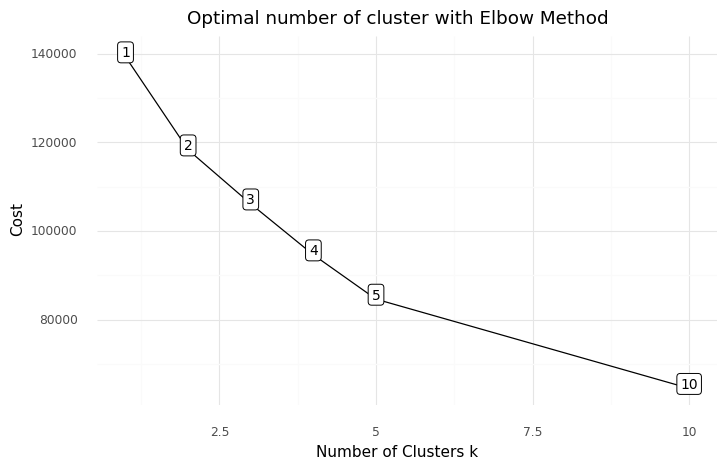

<ggplot: (8734560427365)>

In [ ]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

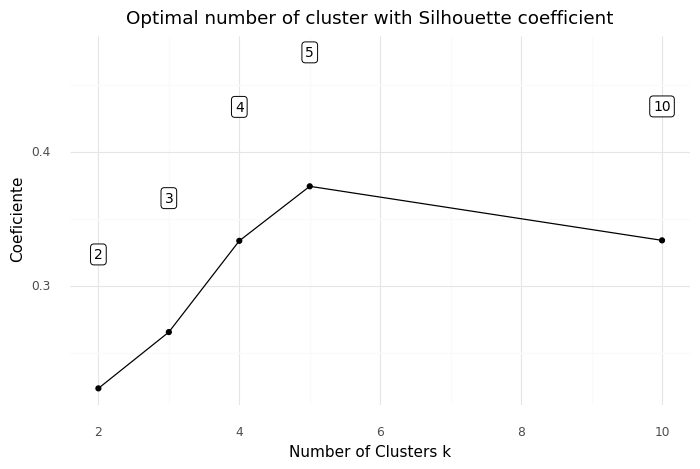

<ggplot: (8734549441245)>

In [ ]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [ ]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', gamma = 0.5, random_state = 0)
kprototype.fit_predict(dfNoSupervisado2, categorical = catColumnsPos)

array([1, 1, 1, ..., 0, 0, 0], dtype=uint16)

In [ ]:
# Add the clusters to the dataframe
dfNoSupervisado2['Cluster Labels'] = kprototype.labels_

In [ ]:
dfNoSupervisado2.to_csv("k2Dims.csv", index = False)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['CAT']) 
contingency

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
Cluster Labels,,,,,,,,,,,,,,,,
0,146,109,1,2334,1879,13,143,89,163,357,103,200,4,144,1746,144
1,0,142,0,220,260,70,2271,3590,24,162,1,0,3,153,475,16


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['IG']) 
contingency

IG,IG10,IG11,IG12,IG13,IG14,IG15,IG16,IG17,IG18,IG19,IG2,IG20,IG21,IG22,IG25,IG26,IG27,IG28,IG29,IG3,IG30,IG31,IG32,IG33,IG34,IG35,IG36,IG37,IG38,IG39,IG4,IG40,IG41,IG42,IG43,IG44,IG45,IG46,IG47,IG48,IG49,IG5,IG50,IG51,IG52,IG53,IG54,IG55,IG56,IG57,IG58,IG6,IG60,IG61,IG62,IG63,IG64,IG65,IG67,IG69,IG7,IG70,IG71,IG8,IG9
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,103,200,61,220,630,29,250,124,16,7,111,4,4,2,0,92,22,0,137,32,734,489,6,165,82,558,43,1,602,135,3,13,6,15,31,34,37,30,0,2,0,89,13,31,0,13,2,80,5,15,4,51,0,900,4,18,728,6,140,56,288,19,8,68,7
1,1,0,13,120,438,0,170,3,10,6,0,6,3,43,90,11,9,1,0,0,2,0,0,0,58,0,2,0,7,64,0,14,0,27,85,37,1516,1451,389,83,36,0,4,622,292,687,477,139,127,14,24,0,5,74,0,0,85,12,58,0,0,7,24,41,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['HTS']) 
contingency

HTS,HTS10,HTS100,HTS101,HTS102,HTS103,HTS104,HTS107,HTS11,HTS110,HTS111,HTS112,HTS114,HTS115,HTS117,HTS119,HTS12,HTS120,HTS121,HTS123,HTS124,HTS132,HTS138,HTS14,HTS140,HTS143,HTS146,HTS148,HTS15,HTS150,HTS151,HTS153,HTS154,HTS155,HTS156,HTS157,HTS158,HTS159,HTS16,HTS161,HTS163,HTS164,HTS165,HTS166,HTS167,HTS168,HTS169,HTS17,HTS170,HTS171,HTS172,HTS173,HTS175,HTS18,HTS19,HTS2,HTS20,HTS21,HTS22,HTS23,HTS24,HTS25,HTS26,HTS27,HTS29,HTS3,HTS32,HTS33,HTS34,HTS35,HTS36,HTS37,HTS38,HTS39,HTS4,HTS40,HTS41,HTS42,HTS43,HTS44,HTS45,HTS46,HTS47,HTS48,HTS49,HTS5,HTS50,HTS51,HTS52,HTS53,HTS54,HTS55,HTS56,HTS58,HTS59,HTS6,HTS60,HTS61,HTS62,HTS63,HTS65,HTS66,HTS67,HTS69,HTS71,HTS72,HTS73,HTS74,HTS75,HTS76,HTS77,HTS78,HTS79,HTS8,HTS80,HTS81,HTS82,HTS83,HTS85,HTS86,HTS89,HTS9,HTS90,HTS91,HTS92,HTS93,HTS94,HTS95,HTS96,HTS97,HTS98,HTS99,No HTS
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,3,6,0,0,0,0,87,301,13,14,0,0,0,7,7,0,0,0,0,68,1675,7,3,0,1,0,0,2,0,0,53,16,0,1,0,4,4,3,0,62,6,0,0,5,0,2,50,0,2,0,0,117,14,5,0,0,0,2,3,33,2,61,196,143,3,51,0,69,61,16,34,0,5,161,41,30,1,0,22,511,16,30,10,432,92,33,29,1147,5,743,46,1,9,30,144,3,0,0,0,0,6,62,0,0,0,2,0,0,0,0,0,0,0,18,0,0,4,5,18,541,0,155,8,1,1
1,3,1,3,1,4,4,3,0,13,2,3,3,12,19,3179,4,5,402,1,4,0,4,9,4,6,1,2,1204,13,0,9,0,3,3,0,1,2,185,2,2,4,2,16,5,0,1,17,12,1,2,7,7,19,21,1,0,1,2,1,1489,22,2,1,2,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,0,0,0,133,0,1,10,0,0,0,0,0,11,0,0,74,0,9,3,0,4,75,6,2,2,3,19,3,5,14,2,9,8,1,5,10,3,1,9,9,4,31,2,1,0,1,0,143,3,1,0,3,9


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['AISLE']) 
contingency

AISLE,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,37,38,39,4,40,41,5,6,7,8,88,9,99
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,30,164,334,540,25,8,10,17,15,12,6,10,985,58,173,179,46,60,63,48,75,156,139,779,142,160,233,153,50,18,532,14,13,740,15,12,196,181,340,379,0,359,106
1,29,9,256,236,996,787,742,788,524,535,281,293,90,167,76,43,35,24,69,32,21,13,8,21,14,9,17,24,54,63,108,40,37,8,5,9,5,9,232,260,83,279,56


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['PLANNING']) 
contingency

PLANNING,1/0,1/1,2/0
Cluster Labels,,,
0,649,6461,465
1,684,6407,296


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['ABC']) 
contingency

ABC,A,B,C
Cluster Labels,,,
0,4493,1174,1908
1,2402,2027,2958


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['UOM']) 
contingency

UOM,BDL,BG,BX,EA,FT,PC,PK,PR,RL,SET,SKID,SQFT,TB,YD
Cluster Labels,,,,,,,,,,,,,,
0,25,89,4691,17,62,47,0,21,67,0,2,602,2,1950
1,11,695,1354,43,223,3574,14,1304,107,1,0,7,40,14


In [ ]:
dfNoSupervisado2[dfNoSupervisado2['Cluster Labels']==0].describe()

,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Cluster Labels
count,7575.000000,7575.000000,7575.000000,7575.000000,7575.000000,7575.000000,7575.000000,7575.0
mean,-0.022071,0.006000,0.259151,0.487464,0.573889,0.658168,0.183258,0.0
std,1.288358,1.317460,1.345123,1.083309,1.076844,0.927609,1.380195,0.0
min,-8.280268,-0.140923,-0.328466,-0.846952,-0.978704,-1.368242,-0.216092,0.0
25%,-0.261226,-0.140923,-0.279047,-0.709712,-0.132244,0.075145,-0.216092,0.0
50%,0.011851,-0.038423,-0.126503,0.662692,0.481726,0.435991,-0.192515,0.0
75%,0.273663,-0.031030,0.714561,1.364143,0.822275,1.157685,-0.027474,0.0
max,8.275201,77.947097,72.602125,2.782295,9.881744,10.058572,10.700178,0.0


In [ ]:
dfNoSupervisado2[dfNoSupervisado2['Cluster Labels']==1].describe()

,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Cluster Labels
count,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.0
mean,0.022633,-0.006153,-0.265747,-0.499870,-0.588494,-0.674919,-0.187922,1.0
std,0.567976,0.495751,0.175517,0.573315,0.390471,0.493474,0.050375,0.0
min,-7.676246,-0.140923,-0.328892,-0.892684,-1.138064,-1.474091,-0.216092,1.0
25%,-0.036831,-0.060383,-0.321285,-0.824079,-0.924129,-1.007396,-0.216092,1.0
50%,0.028767,-0.035491,-0.306474,-0.770708,-0.705829,-0.706690,-0.192515,1.0
75%,0.085537,-0.030914,-0.275731,-0.412358,-0.378378,-0.357872,-0.192515,1.0
max,7.530855,21.898775,1.771500,2.035097,1.695476,1.352542,0.279030,1.0


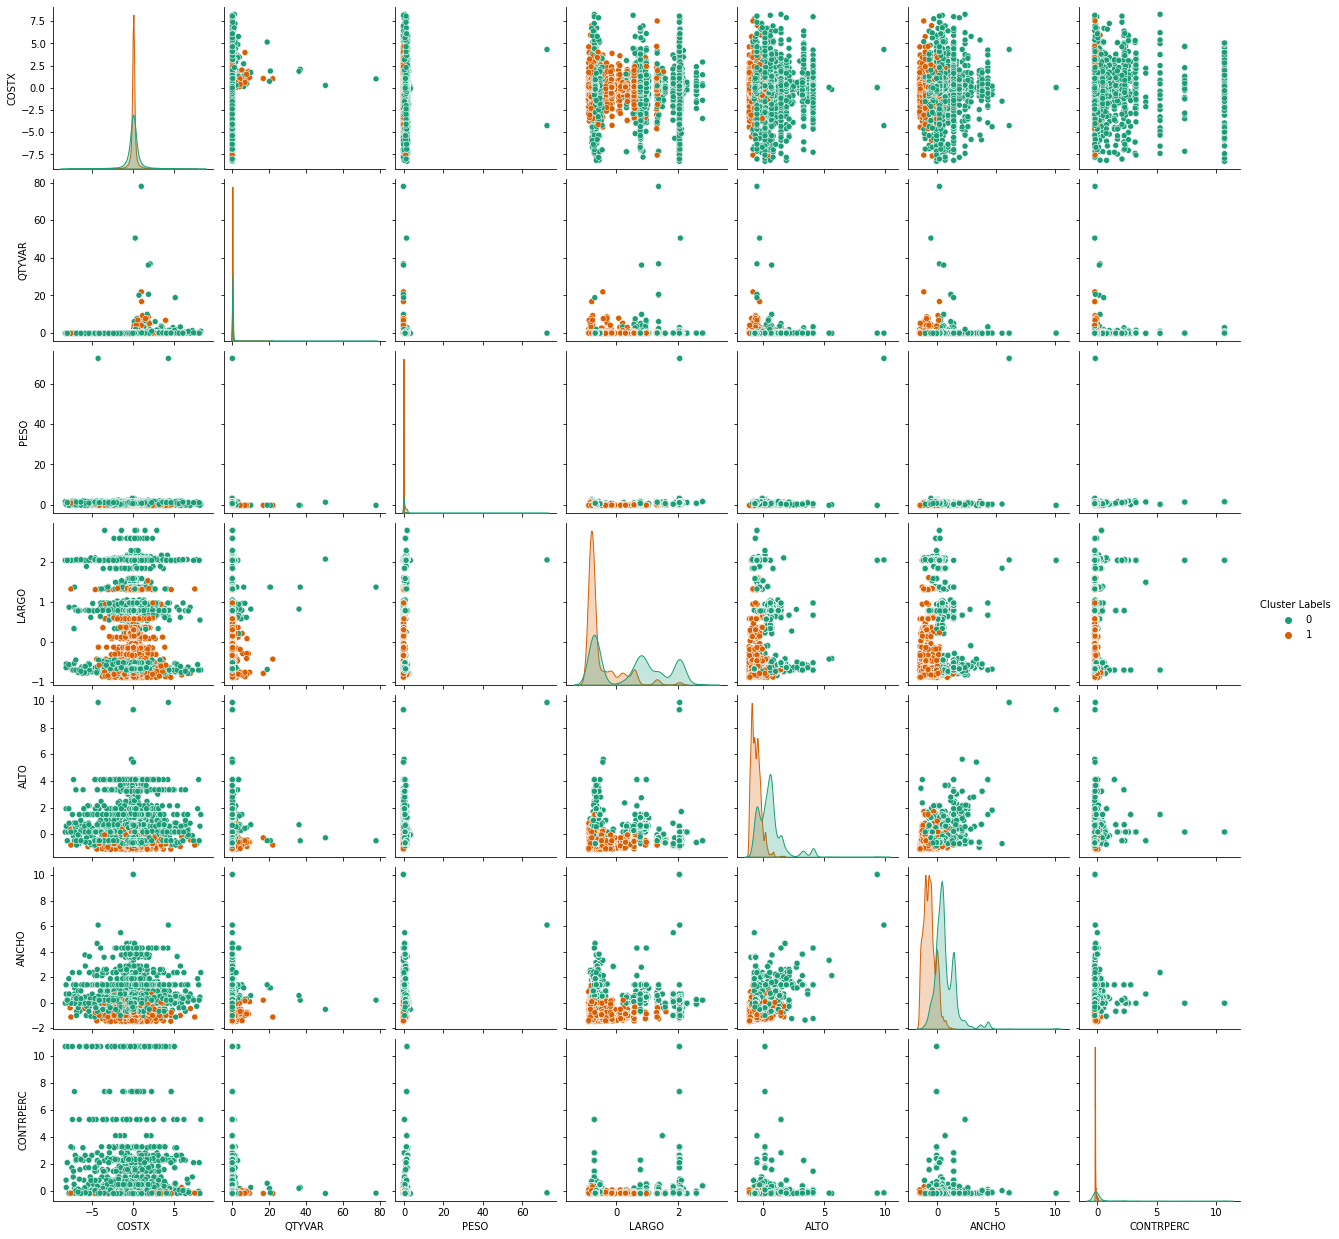

In [ ]:
sns.pairplot(dfNoSupervisado2,hue='Cluster Labels',palette='Dark2',diag_kind='kde')

In [ ]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', gamma = 0.5, random_state = 0)
kprototype.fit_predict(dfNoSupervisado2, categorical = catColumnsPos)

array([0, 0, 0, ..., 2, 2, 2], dtype=uint16)

In [ ]:
# Add the clusters to the dataframe
dfNoSupervisado2['Cluster Labels'] = kprototype.labels_

In [ ]:
dfNoSupervisado2.to_csv("k3Dims.csv", index = False)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['CAT']) 
contingency

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
Cluster Labels,,,,,,,,,,,,,,,,
0,0,142,0,220,260,70,2266,3513,20,161,1,0,3,153,468,16
1,146,73,0,2198,1161,13,53,39,64,273,0,12,4,144,687,132
2,0,36,1,136,718,0,95,127,103,85,103,188,0,0,1066,12


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['IG']) 
contingency

IG,IG10,IG11,IG12,IG13,IG14,IG15,IG16,IG17,IG18,IG19,IG2,IG20,IG21,IG22,IG25,IG26,IG27,IG28,IG29,IG3,IG30,IG31,IG32,IG33,IG34,IG35,IG36,IG37,IG38,IG39,IG4,IG40,IG41,IG42,IG43,IG44,IG45,IG46,IG47,IG48,IG49,IG5,IG50,IG51,IG52,IG53,IG54,IG55,IG56,IG57,IG58,IG6,IG60,IG61,IG62,IG63,IG64,IG65,IG67,IG69,IG7,IG70,IG71,IG8,IG9
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,9,119,438,0,170,3,10,6,0,6,3,43,90,11,9,1,0,0,2,0,0,0,58,0,2,0,0,64,0,14,0,27,85,37,1480,1451,389,43,36,0,4,622,288,687,477,138,126,14,24,0,5,74,0,0,85,12,58,0,0,7,24,41,0
1,0,12,61,211,592,0,245,1,13,7,111,0,4,2,0,92,22,0,1,32,733,489,6,165,81,555,43,0,0,123,3,13,6,15,24,34,24,0,0,0,0,0,0,30,0,13,2,4,0,15,4,0,0,208,0,0,724,6,140,56,6,19,8,37,7
2,103,188,4,10,38,29,5,123,3,0,0,4,0,0,0,0,0,0,136,0,1,0,0,0,1,3,0,1,609,12,0,0,0,0,7,0,49,30,0,42,0,89,13,1,4,0,0,77,6,0,0,51,0,692,4,18,4,0,0,0,282,0,0,31,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['HTS']) 
contingency

HTS,HTS10,HTS100,HTS101,HTS102,HTS103,HTS104,HTS107,HTS11,HTS110,HTS111,HTS112,HTS114,HTS115,HTS117,HTS119,HTS12,HTS120,HTS121,HTS123,HTS124,HTS132,HTS138,HTS14,HTS140,HTS143,HTS146,HTS148,HTS15,HTS150,HTS151,HTS153,HTS154,HTS155,HTS156,HTS157,HTS158,HTS159,HTS16,HTS161,HTS163,HTS164,HTS165,HTS166,HTS167,HTS168,HTS169,HTS17,HTS170,HTS171,HTS172,HTS173,HTS175,HTS18,HTS19,HTS2,HTS20,HTS21,HTS22,HTS23,HTS24,HTS25,HTS26,HTS27,HTS29,HTS3,HTS32,HTS33,HTS34,HTS35,HTS36,HTS37,HTS38,HTS39,HTS4,HTS40,HTS41,HTS42,HTS43,HTS44,HTS45,HTS46,HTS47,HTS48,HTS49,HTS5,HTS50,HTS51,HTS52,HTS53,HTS54,HTS55,HTS56,HTS58,HTS59,HTS6,HTS60,HTS61,HTS62,HTS63,HTS65,HTS66,HTS67,HTS69,HTS71,HTS72,HTS73,HTS74,HTS75,HTS76,HTS77,HTS78,HTS79,HTS8,HTS80,HTS81,HTS82,HTS83,HTS85,HTS86,HTS89,HTS9,HTS90,HTS91,HTS92,HTS93,HTS94,HTS95,HTS96,HTS97,HTS98,HTS99,No HTS
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,1,3,1,4,4,3,0,13,2,3,3,12,19,3174,4,5,402,1,4,0,4,9,4,6,1,2,1204,13,0,9,0,3,3,0,1,2,185,2,2,4,2,16,5,0,1,17,12,1,2,7,7,19,21,1,0,1,2,1,1413,22,2,1,2,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2,0,0,0,133,0,1,10,0,0,0,0,0,11,0,0,74,0,2,3,0,0,75,6,2,2,3,19,3,5,14,2,9,8,1,5,10,3,1,9,9,4,31,2,1,0,0,0,142,3,1,0,3,9
1,0,0,0,1,0,0,0,2,6,0,0,0,0,87,296,0,14,0,0,0,7,7,0,0,0,0,68,1666,7,3,0,1,0,0,2,0,0,53,16,0,1,0,4,4,3,0,62,6,0,0,5,0,2,50,0,2,0,0,0,13,5,0,0,0,2,3,33,2,61,196,143,3,51,0,69,61,16,34,0,5,160,41,30,1,0,22,508,16,30,10,432,92,33,29,208,0,9,46,1,0,0,0,0,0,0,0,0,6,62,0,0,0,2,0,0,0,0,0,0,0,18,0,0,0,0,6,8,0,155,0,1,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,13,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,939,5,741,0,0,13,30,144,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,12,534,0,0,8,0,0


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['AISLE']) 
contingency

AISLE,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,37,38,39,4,40,41,5,6,7,8,88,9,99
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29,9,256,236,995,787,742,788,524,535,281,292,82,127,68,24,31,23,59,32,20,13,8,21,14,9,16,24,54,63,108,40,37,8,5,9,5,9,232,260,83,279,56
1,22,162,330,538,23,8,10,17,15,12,0,0,284,0,3,8,1,0,0,1,1,25,30,778,38,39,42,36,0,10,532,14,13,736,15,11,42,38,339,378,0,359,89
2,8,2,4,2,3,0,0,0,0,0,6,11,709,98,178,190,49,61,73,47,75,131,109,1,104,121,192,117,50,8,0,0,0,4,0,1,154,143,1,1,0,0,17


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['PLANNING']) 
contingency

PLANNING,1/0,1/1,2/0
Cluster Labels,,,
0,660,6362,271
1,463,4204,332
2,210,2302,158


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['ABC']) 
contingency

ABC,A,B,C
Cluster Labels,,,
0,2365,1975,2953
1,2984,710,1305
2,1546,516,608


In [ ]:
contingency = pd.crosstab(dfNoSupervisado2['Cluster Labels'], dfNoSupervisado2['UOM']) 
contingency

UOM,BDL,BG,BX,EA,FT,PC,PK,PR,RL,SET,SKID,SQFT,TB,YD
Cluster Labels,,,,,,,,,,,,,,
0,6,695,1318,43,223,3569,14,1303,107,1,0,0,0,14
1,0,62,2837,17,6,42,0,22,67,0,0,0,0,1946
2,30,27,1890,0,56,10,0,0,0,0,2,609,42,4


In [ ]:
dfNoSupervisado2[dfNoSupervisado2['Cluster Labels']==0].describe()

,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Cluster Labels
count,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.0
mean,0.021652,-0.005465,-0.266545,-0.530813,-0.585418,-0.670617,-0.187850,0.0
std,0.543428,0.498852,0.174467,0.505942,0.390399,0.494913,0.050587,0.0
min,-7.676246,-0.140923,-0.328892,-0.892684,-1.138064,-1.474091,-0.216092,0.0
25%,-0.035105,-0.059207,-0.321554,-0.824079,-0.924129,-1.007396,-0.216092,0.0
50%,0.029133,-0.035438,-0.306474,-0.770708,-0.651254,-0.706690,-0.192515,0.0
75%,0.084333,-0.030883,-0.277302,-0.442856,-0.349999,-0.345843,-0.192515,0.0
max,7.005862,21.898775,1.771500,1.333646,1.695476,1.352542,0.279030,0.0


In [ ]:
dfNoSupervisado2[dfNoSupervisado2['Cluster Labels']==1].describe()

,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Cluster Labels
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.0
mean,-0.021306,-0.023267,-0.012893,-0.134398,0.957509,0.928122,0.017978,1.0
std,1.183027,0.410803,0.445520,0.726838,1.090553,0.949945,0.619109,0.0
min,-8.174124,-0.140923,-0.327613,-0.846952,-0.978704,-1.368242,-0.216092,1.0
25%,-0.270822,-0.140923,-0.283203,-0.744022,0.440249,0.435991,-0.216092,1.0
50%,0.006672,-0.039330,-0.239153,-0.648716,0.603974,0.556274,-0.192515,1.0
75%,0.271607,-0.029733,0.145474,0.662692,1.171555,1.398249,-0.027474,1.0
max,8.275201,18.840635,2.579351,2.035097,9.335993,10.058572,5.277409,1.0


In [ ]:
dfNoSupervisado2[dfNoSupervisado2['Cluster Labels']==2].describe()

,COSTX,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Cluster Labels
count,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.000000,2670.0
mean,-0.019249,0.058490,0.752197,1.701525,-0.193684,0.094055,0.479446,2.0
std,1.475024,2.146023,2.095360,0.466031,0.520719,0.629030,2.134035,0.0
min,-8.280268,-0.140923,-0.328466,0.243347,-0.978704,-1.247960,-0.216092,2.0
25%,-0.256905,-0.119698,-0.014750,1.364143,-0.487528,-0.285702,-0.216092,2.0
50%,0.026767,-0.036640,0.821376,2.035097,-0.269228,-0.045138,-0.192515,2.0
75%,0.281071,-0.033693,1.320449,2.035097,0.167373,0.405921,-0.051051,2.0
max,8.080268,77.947097,72.602125,2.782295,9.881744,6.089257,10.700178,2.0


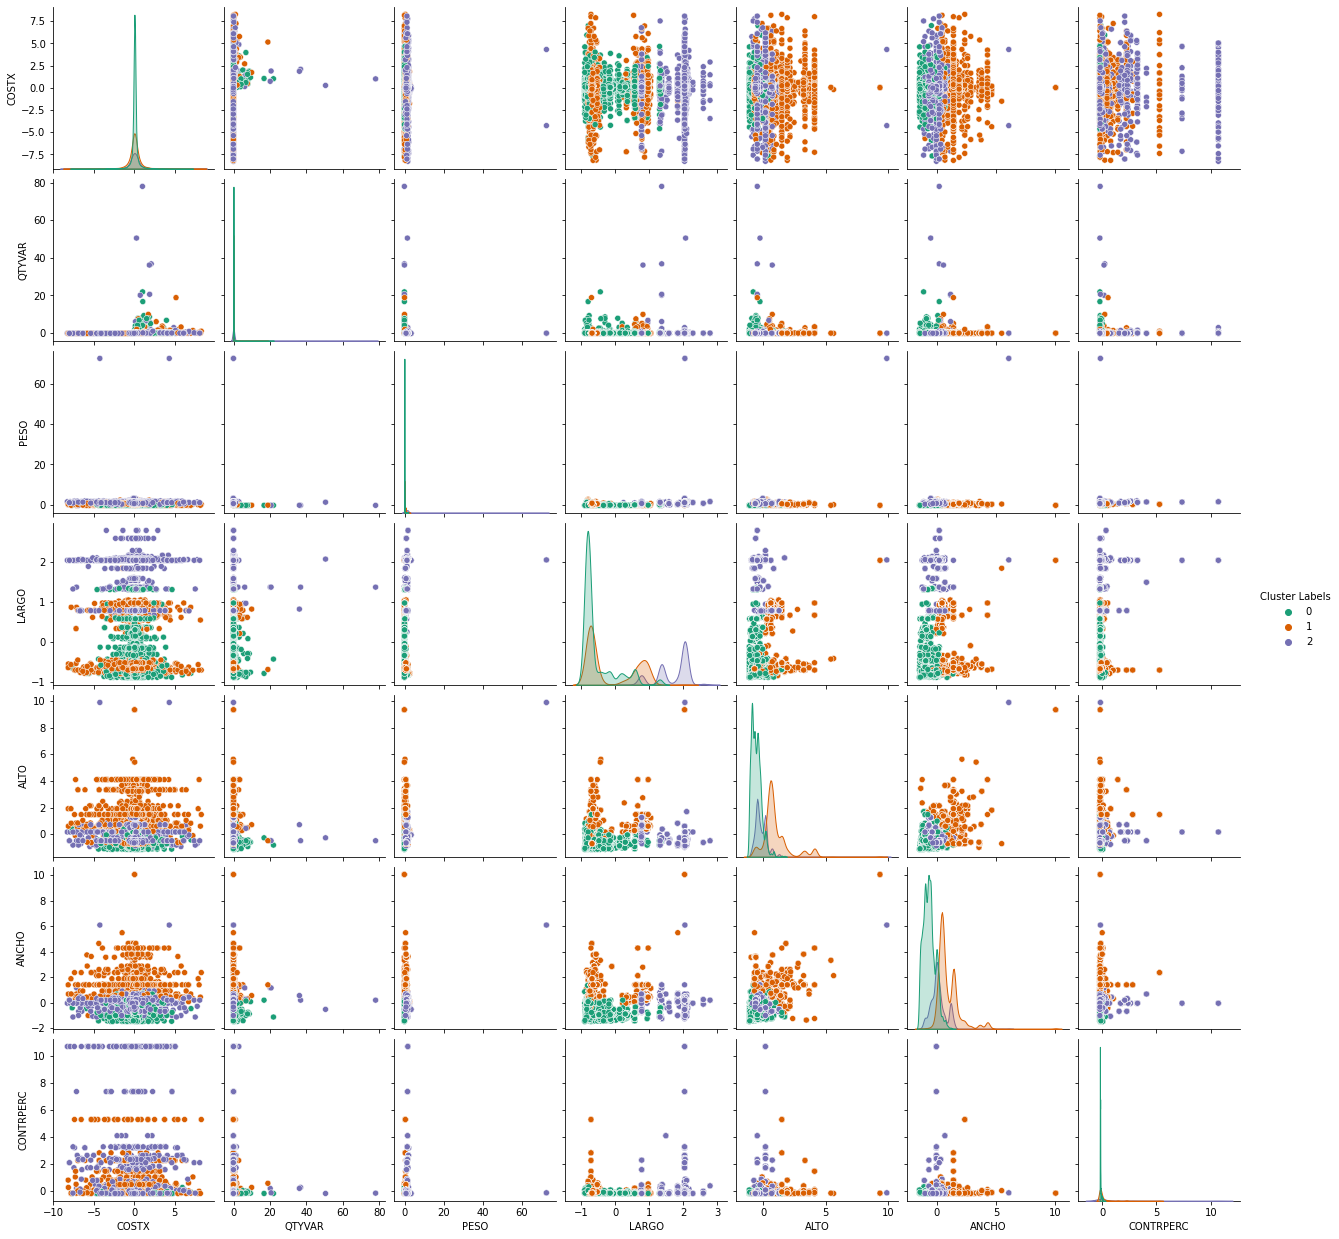

In [ ]:
sns.pairplot(dfNoSupervisado2,hue='Cluster Labels',palette='Dark2',diag_kind='kde')

In [ ]:
# np.savetxt("scores.csv", scores, delimiter=",")

In [ ]:
# np.savetxt("scores2.csv", scores2, delimiter=",")

In [ ]:
# !ls -l
# from google.colab import files
# files.download('scores.csv')

total 11917292
-rw-r--r-- 1 root root    1108073 Apr 11 20:11 dfDims.csv
-rw-r--r-- 1 root root     795978 Apr 11 19:07 dfNoDims.csv
-rw-r--r-- 1 root root    2569549 Apr 11 21:02 k2Dims.csv
-rw-r--r-- 1 root root    1506267 Apr 11 20:09 k2NoDims.csv
-rw-r--r-- 1 root root    2569549 Apr 11 21:04 k3Dims.csv
-rw-r--r-- 1 root root    1506267 Apr 11 20:10 k3NoDims.csv
drwxr-xr-x 1 root root       4096 Apr  7 13:36 sample_data
-rw-r--r-- 1 root root 5596536100 Apr 11 21:39 scores2.csv
-rw-r--r-- 1 root root 6596688400 Apr 11 15:24 scores.csv
